This file analyzed and compares the spikes vs. the background signal and looks at their DCT transform

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.fftpack import idct
from scipy.signal import butter, filtfilt
from scipy.io import savemat, loadmat
from pathlib import Path

import sys
sys.path.append("C:/Users/ariaa/OneDrive - NTNU/Masteroppgave/Code & Data")
from src.data.matToNpy import matToNpy

plt.rc('font', size=10)    
plt.rc('axes', titlesize=16)    
plt.rc('axes', labelsize=16)    

np.random.seed(1)


filename = 'hc1_d533101_extracellular' 
matlab = True
fs = 10_000

pp = 60 # windown for DCT - ish. 2ms (two APs)
qq = 1 # windown size in channels for DCT
N_ch = 4

base = 240000 # sample starting point (needed because of how the signal is compressed with the first section as training set)

n_spikes = 20 # num windows to use in DCT

t_spike = 3481 #time of spike (time of intracellular spike detected in extracellular signal)
# dt_spike = 10 # parameter for window size around spike
# dt_spike = 0.002*fs
dt_spike = pp/30000*fs

f_low = 300
f_high = 4000

# load intracellular spikes
base_folder = Path('C:/Users/ariaa/OneDrive - NTNU/Masteroppgave/Code & Data/data/mat')
s_intra = loadmat(base_folder / 'hc1_d533101_intracellular.mat', mat_dtype=True)['x'].T[:,0]

# choose to load data from .npy or .mat file
if matlab == True: 
    s1 = matToNpy(filename) 
else:
    base_folder = Path('C:/Users/ariaa\OneDrive - NTNU/Masteroppgave/Code & Data/data/npy')
    s1 = np.load(base_folder / (filename + '.npy'))

t_max = s1.shape[0]/fs
ts = np.linspace(0,t_max, int(s1.shape[0])) # time 

In [2]:
# load spike times
base_folder = Path('C:/Users/ariaa/OneDrive - NTNU/Masteroppgave/Code & Data/data/npy')

bad_spikes = [2,6,9] # manually removed spikes that are a bit off center
t_spikes = np.load(base_folder / 'spike_times_true_240000.npy')[:n_spikes + len(bad_spikes)]
t_spikes = np.delete(t_spikes, bad_spikes)
print('Spike times:')
print(t_spikes)

Spike times:
[  3481  84679  84728  84768  84799  88101  88153  88325  93044  93059
  93820  99123 102219 107980 115320 115353 115380 117984 117999 123381]


In [3]:
#Get time frames around spike times
spike_intervals = []
for i in range(n_spikes):
    spike_intervals.append([int(base + t_spikes[i] - dt_spike), int(base + t_spikes[i] + dt_spike*2)])

### Define DCT

In [4]:
# generate DCT basis

D = np.zeros((pp, pp))

# generate DCT basis
for p in range(pp):
    a = np.zeros(pp)
    a[p] = 1
    D[:, p] = idct(a, norm='ortho') # use idct on the atom

if qq == 1: #<----------------------------1D DCT
    def getDCT(temp):
        nSteps = int(temp.shape[0]/pp)
        c_mat = np.zeros((pp, nSteps, temp.shape[1]))

        for j in range(temp.shape[1]):
            for i in range(nSteps):
                c_mat[:,i,j] = D.T@temp[pp*i:pp*i + pp, j]

        return c_mat

    def getiDCT(temp):
        #nSteps = int(s1.shape[0]/pp)
        nSteps = int((temp.shape[0]*temp.shape[1])/pp)
        #d_hat = np.zeros_like(s1)
        d_hat = np.zeros((temp.shape[0]*temp.shape[1], temp.shape[2]))

        for j in range(temp.shape[2]): 
            for i in range(nSteps):
                d_hat[pp*i:pp*i + pp, j] = D@temp[:,i,j]
            
        return d_hat
else: #<----------------------------2D DCT

    def getDCT(temp):
        xSteps = temp.shape[0]//pp
        ySteps = temp.shape[1]//qq
        c_mat = np.zeros((pp, xSteps, qq, ySteps))

        for j in range(ySteps):
            for i in range(xSteps):
                c_mat[:,i, :,j] = D.T@temp[pp*i:pp*i + pp, qq*j:qq*j + qq]

        return c_mat

    def getiDCT(temp):
        xSteps = (temp.shape[0]*temp.shape[1])//pp
        ySteps = (temp.shape[2]*temp.shape[3])//qq

        d_hat = np.zeros((temp.shape[0]*temp.shape[1], temp.shape[2]*temp.shape[3]))

        for j in range(ySteps): 
            for i in range(xSteps):
                d_hat[pp*i:pp*i + pp, qq*j:qq*j + qq] = D@temp[:,i, :,j]
            
        return d_hat


### Define Filter

In [5]:
low = f_low  / (fs/2)
high = f_high  / (fs/2)

b,   a = butter(10, [low, high], btype='band')

### Filter and get spikes

In [6]:
# filter to get EAP signal
temp = s1 

AP1  = np.zeros_like(temp)
for i in range(temp.shape[1]):
    AP1[:,i]  = filtfilt(b,a, temp[:,i])

# use only the desired part
AP1 = AP1[:,:N_ch] 


AP_intra = np.zeros([len(s_intra),1])
AP_intra[:,0]  = filtfilt(b,a, s_intra) 

### Inspect noise and spikes

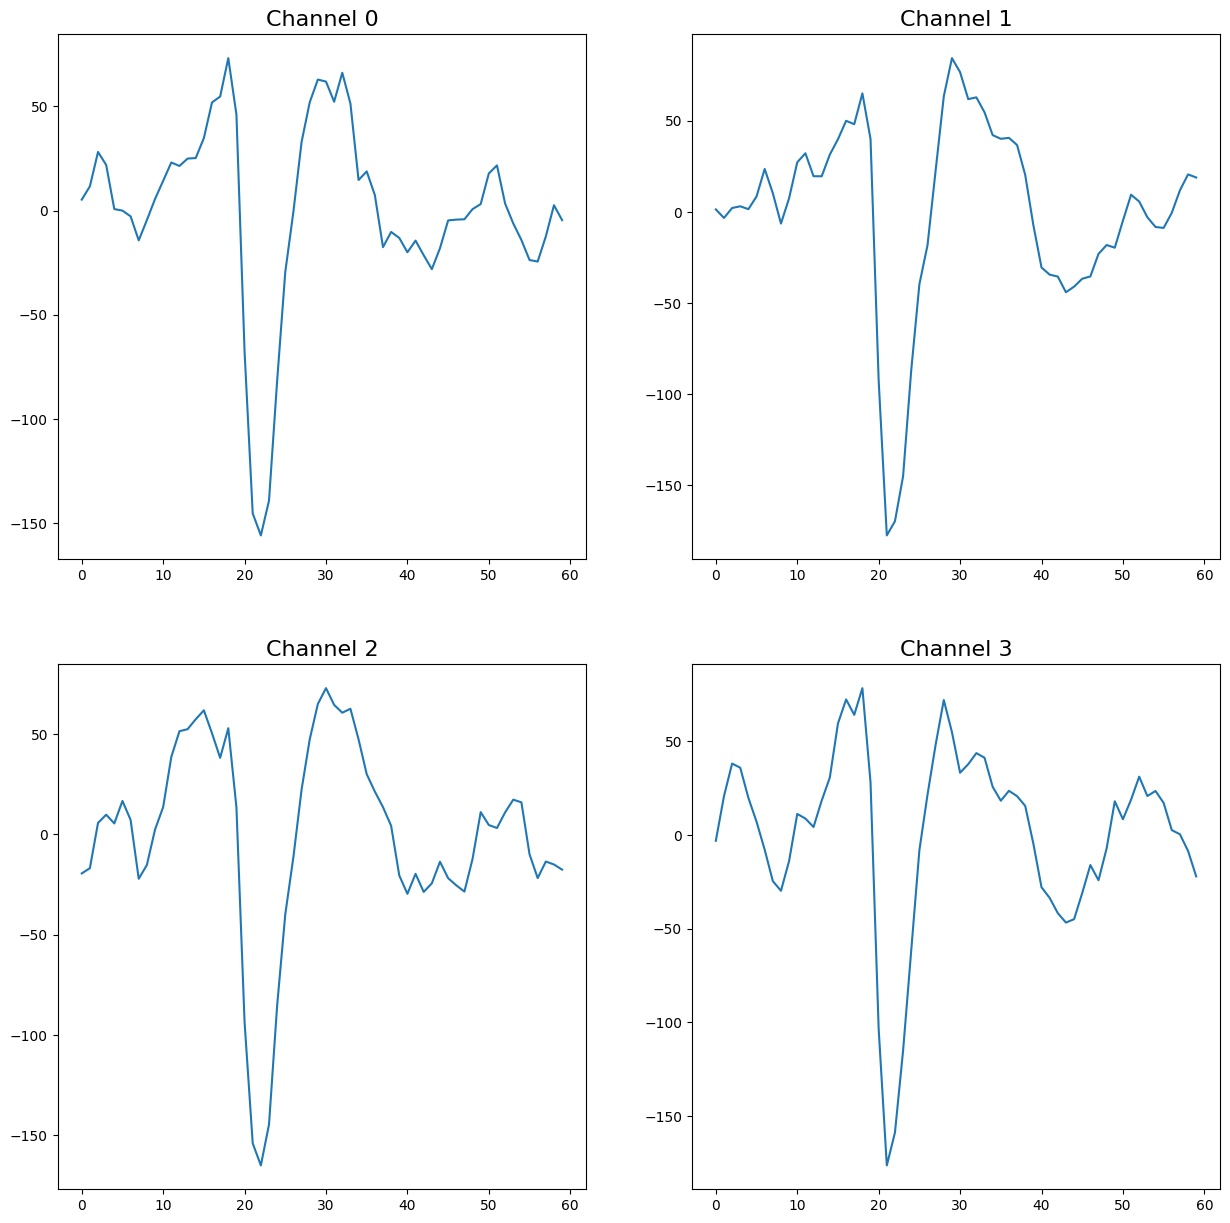

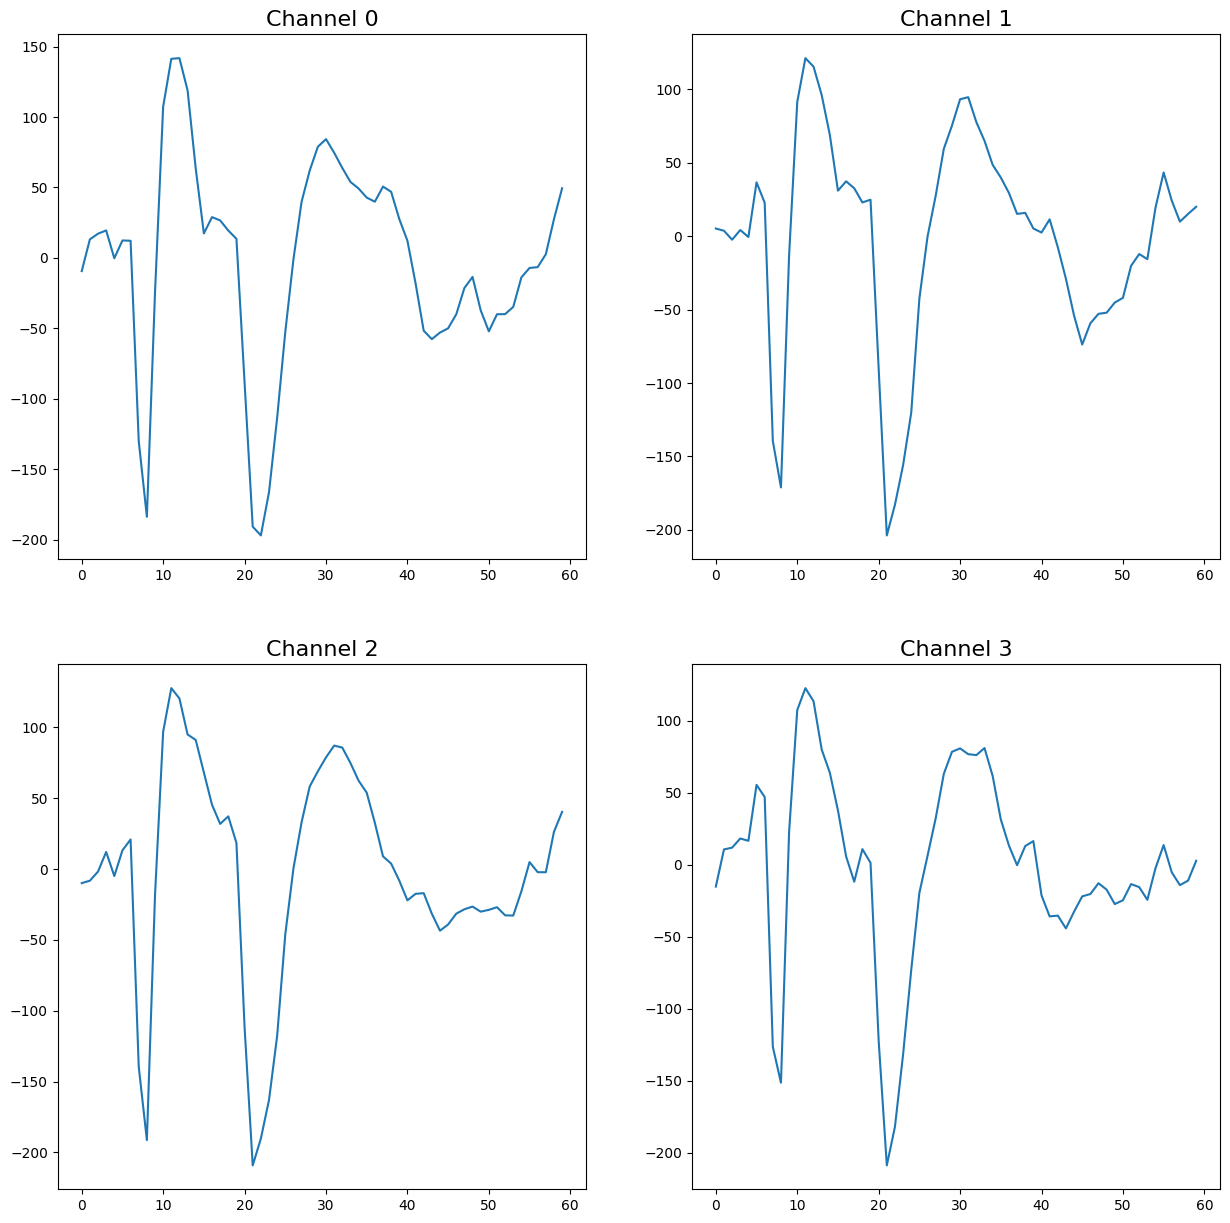

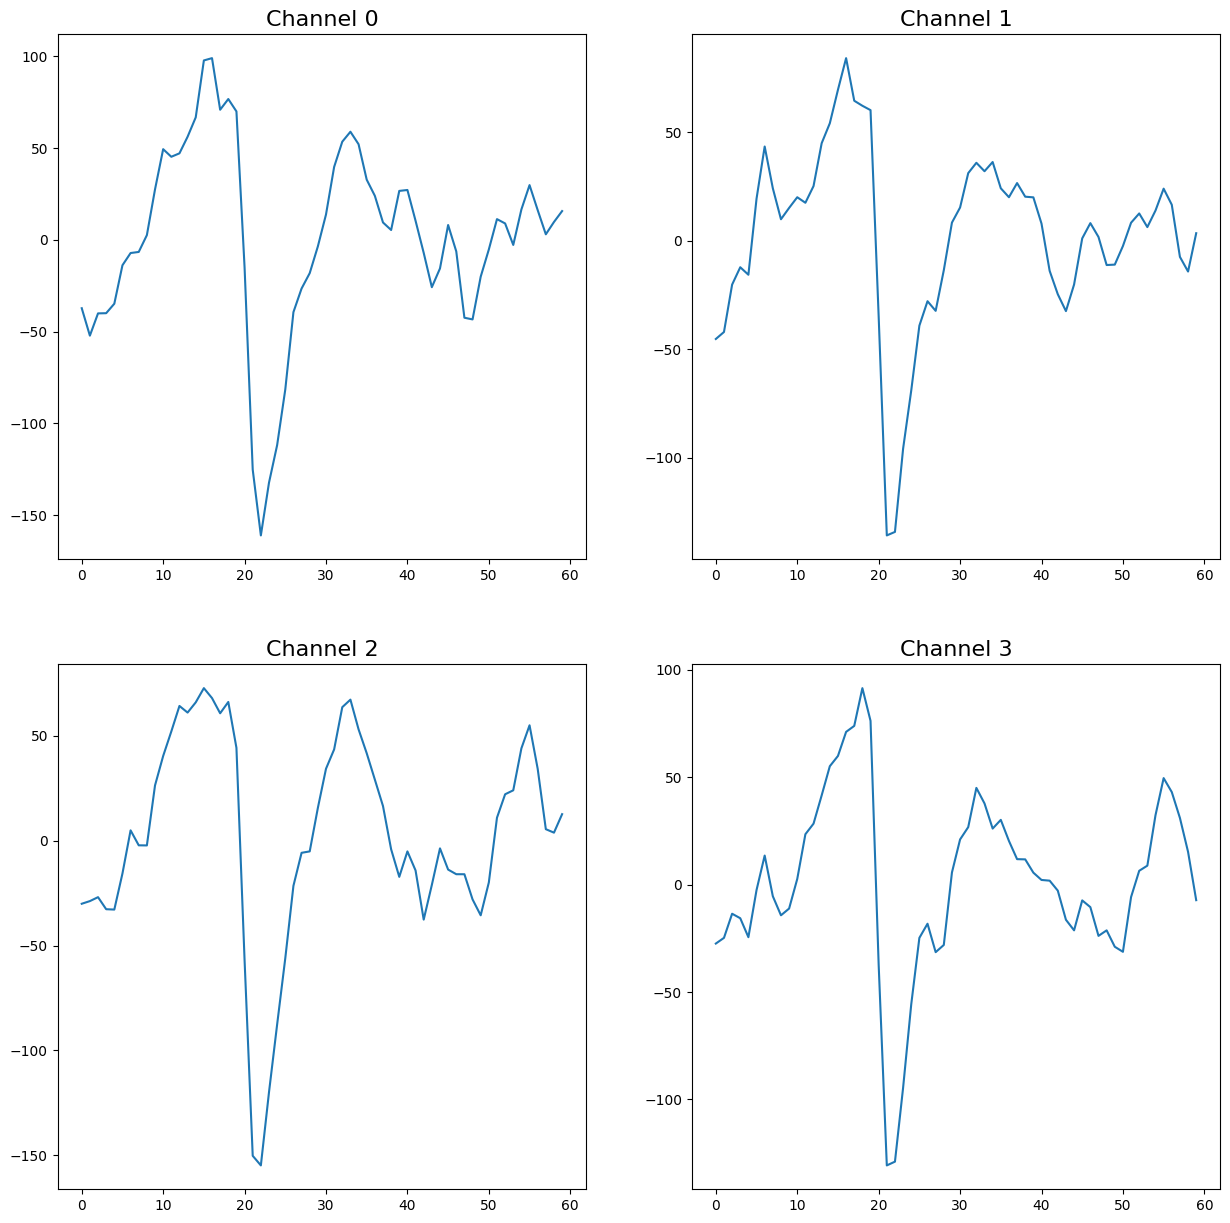

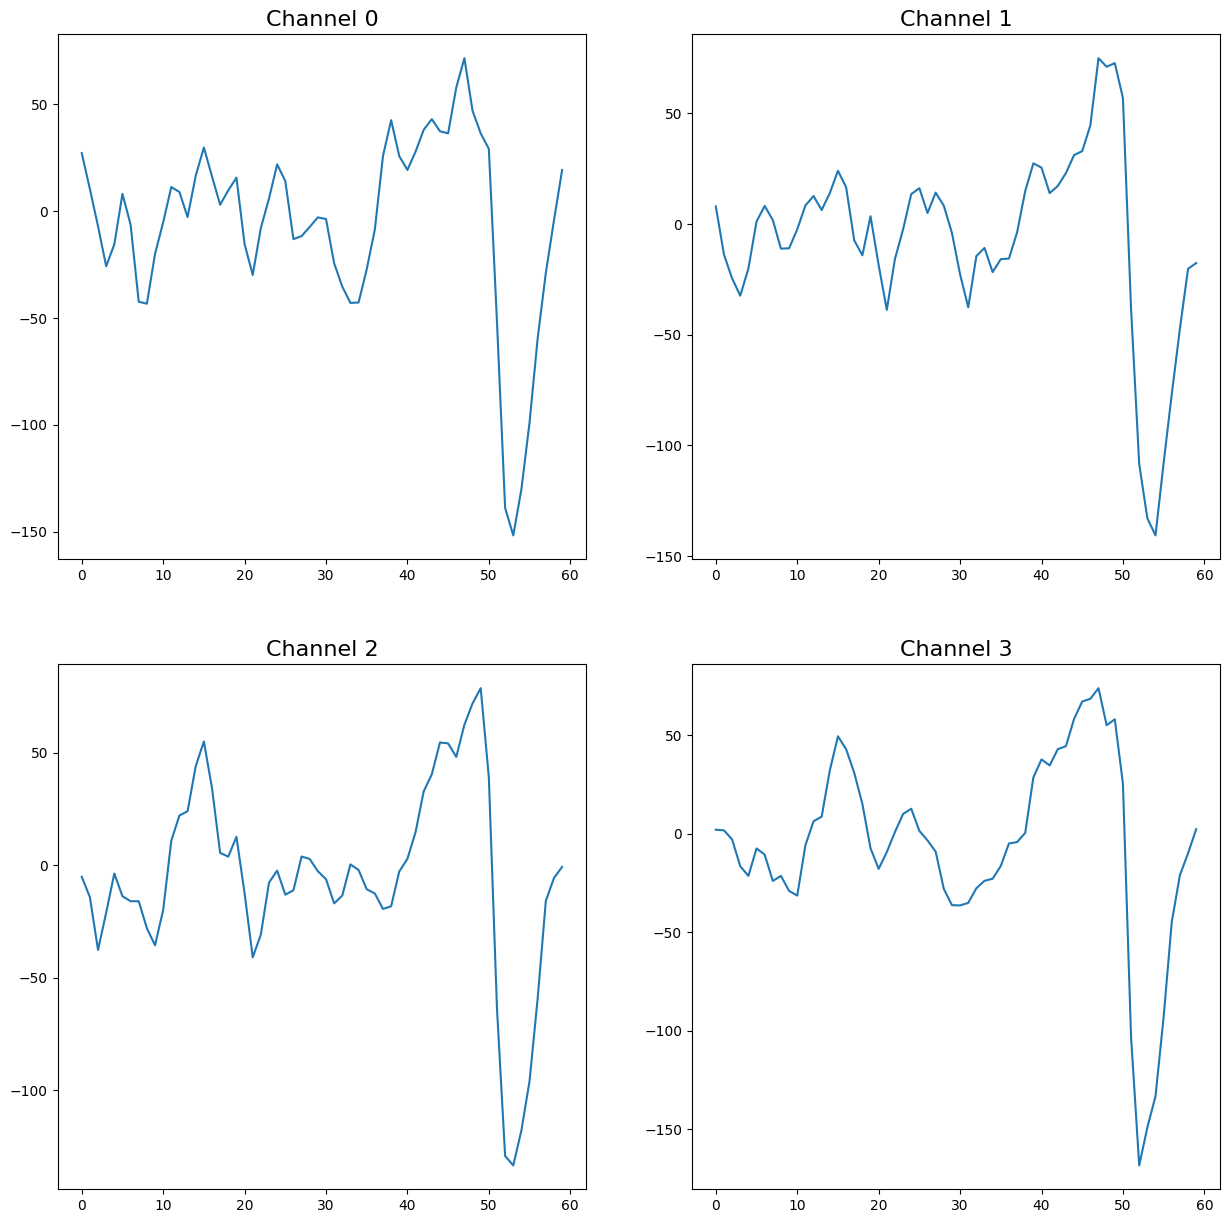

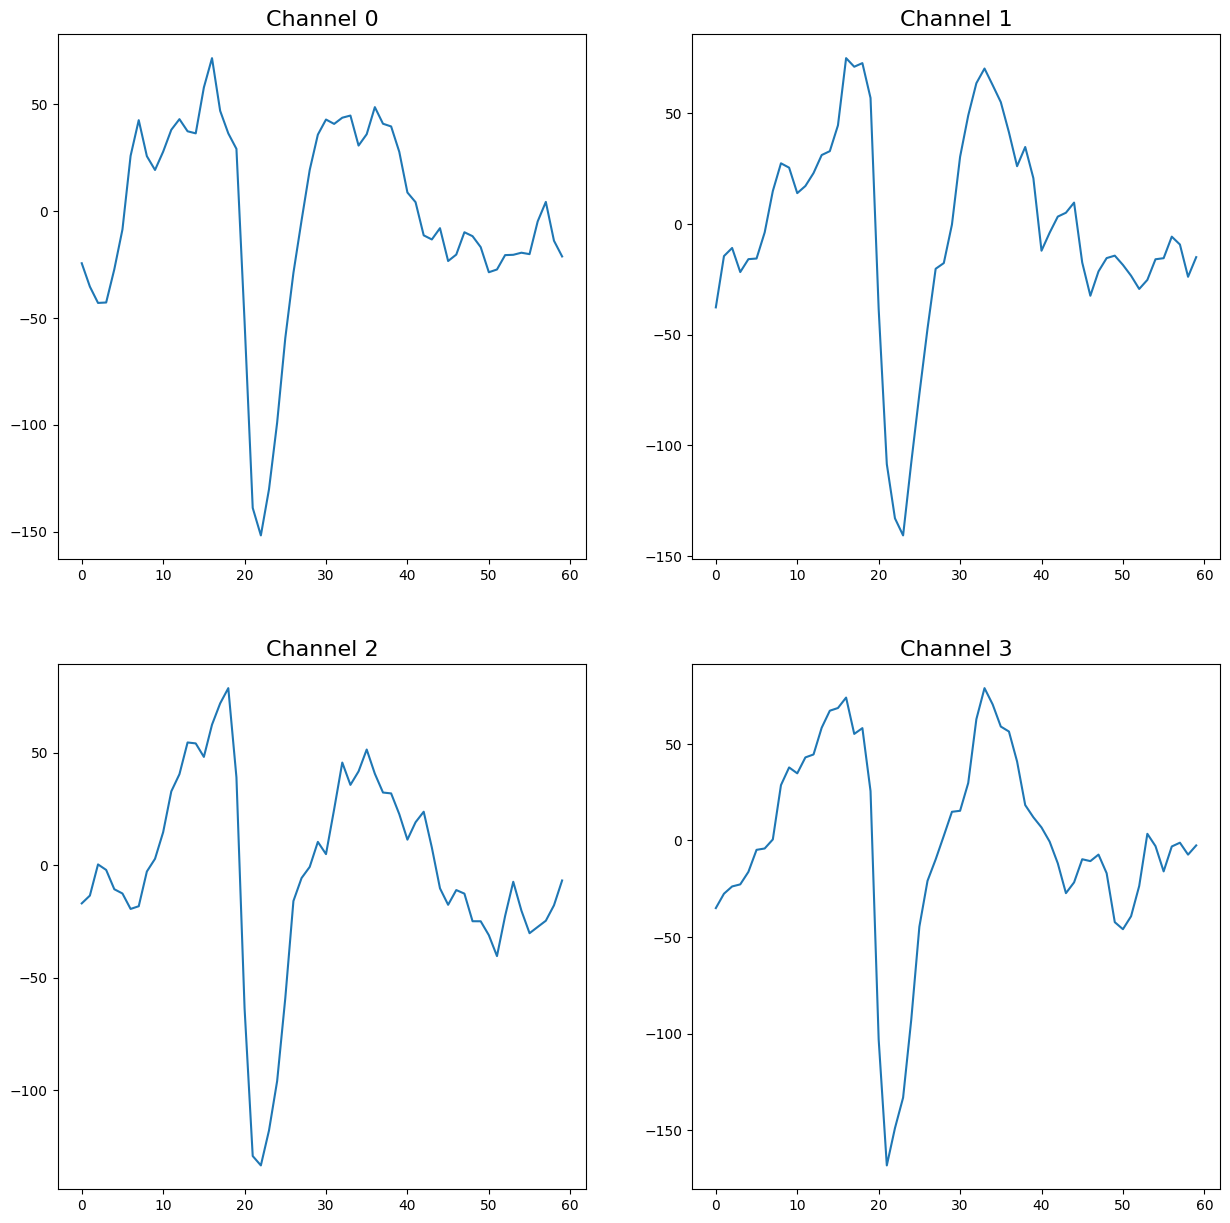

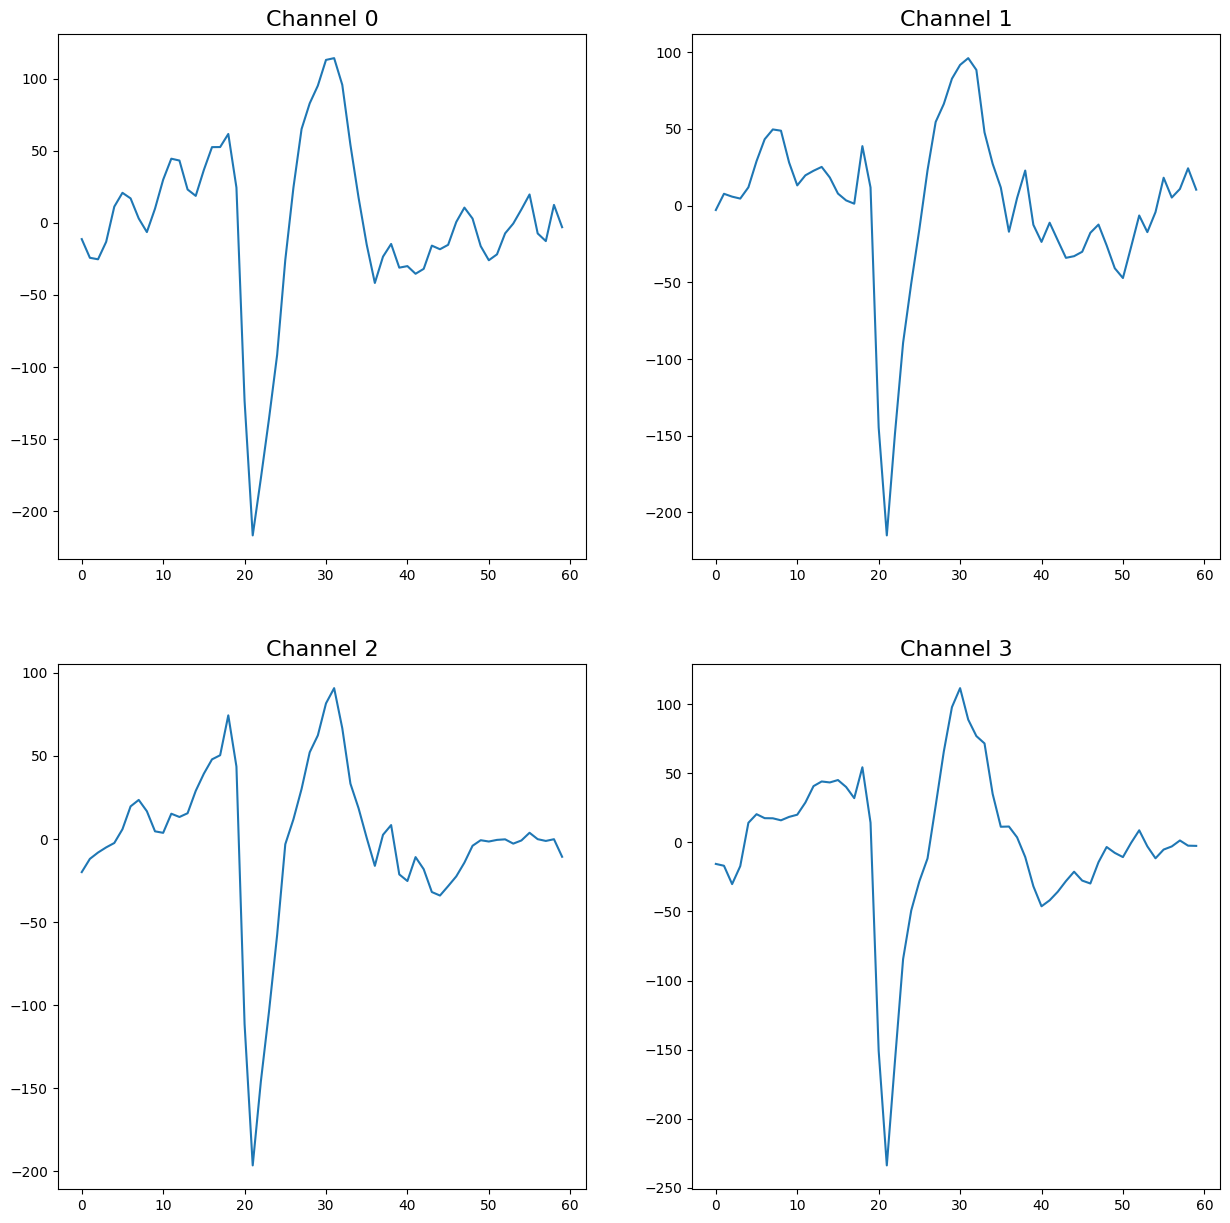

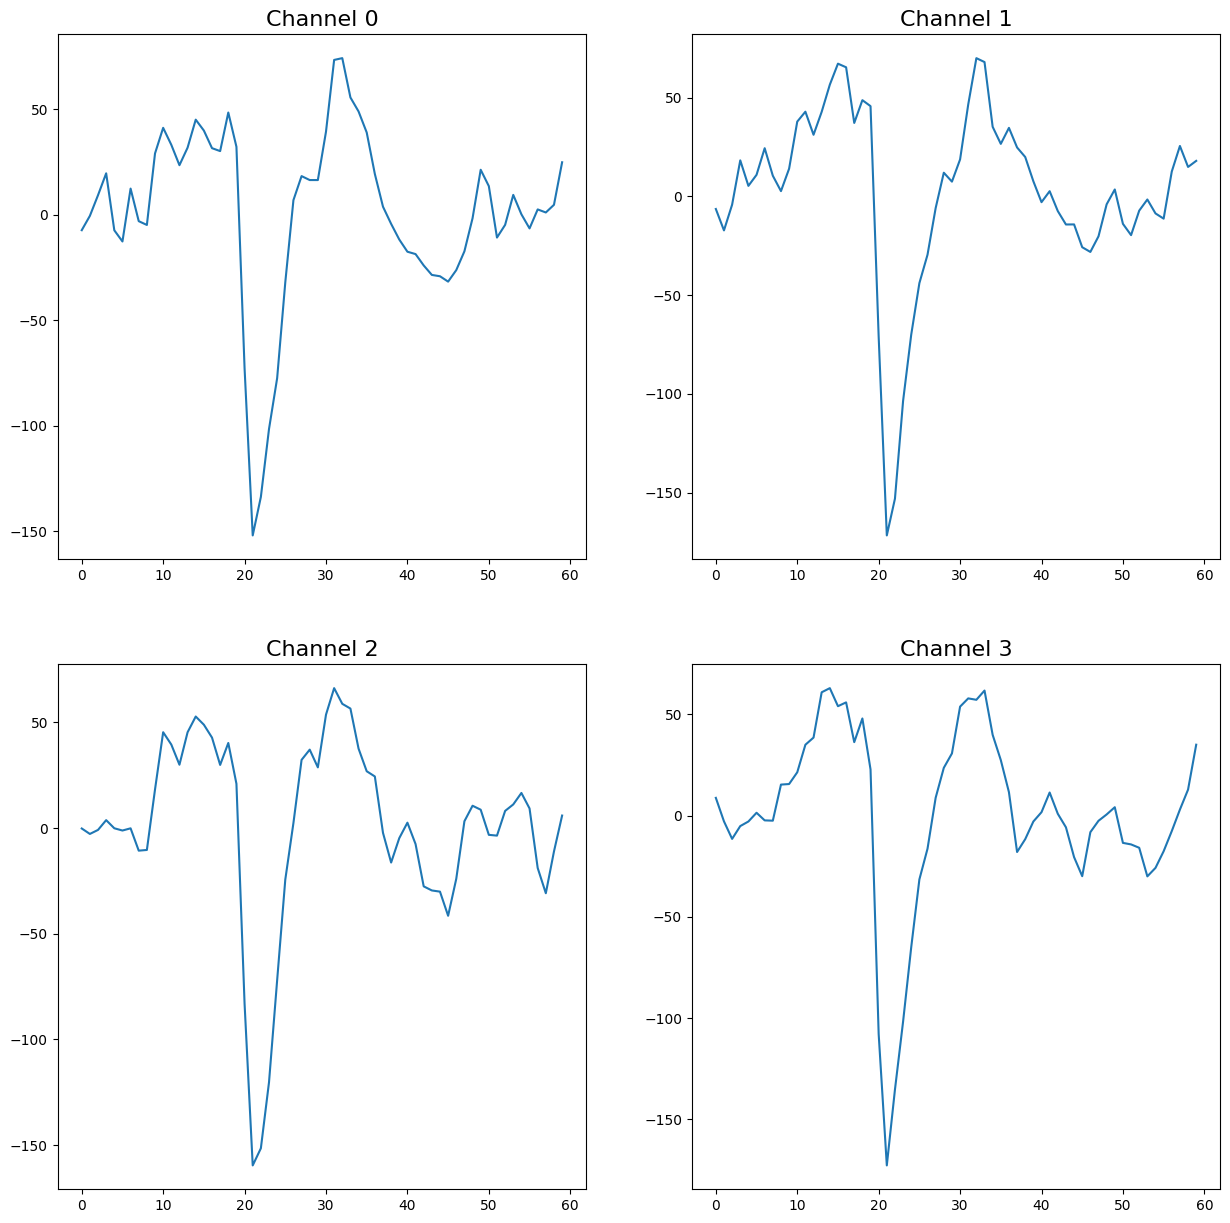

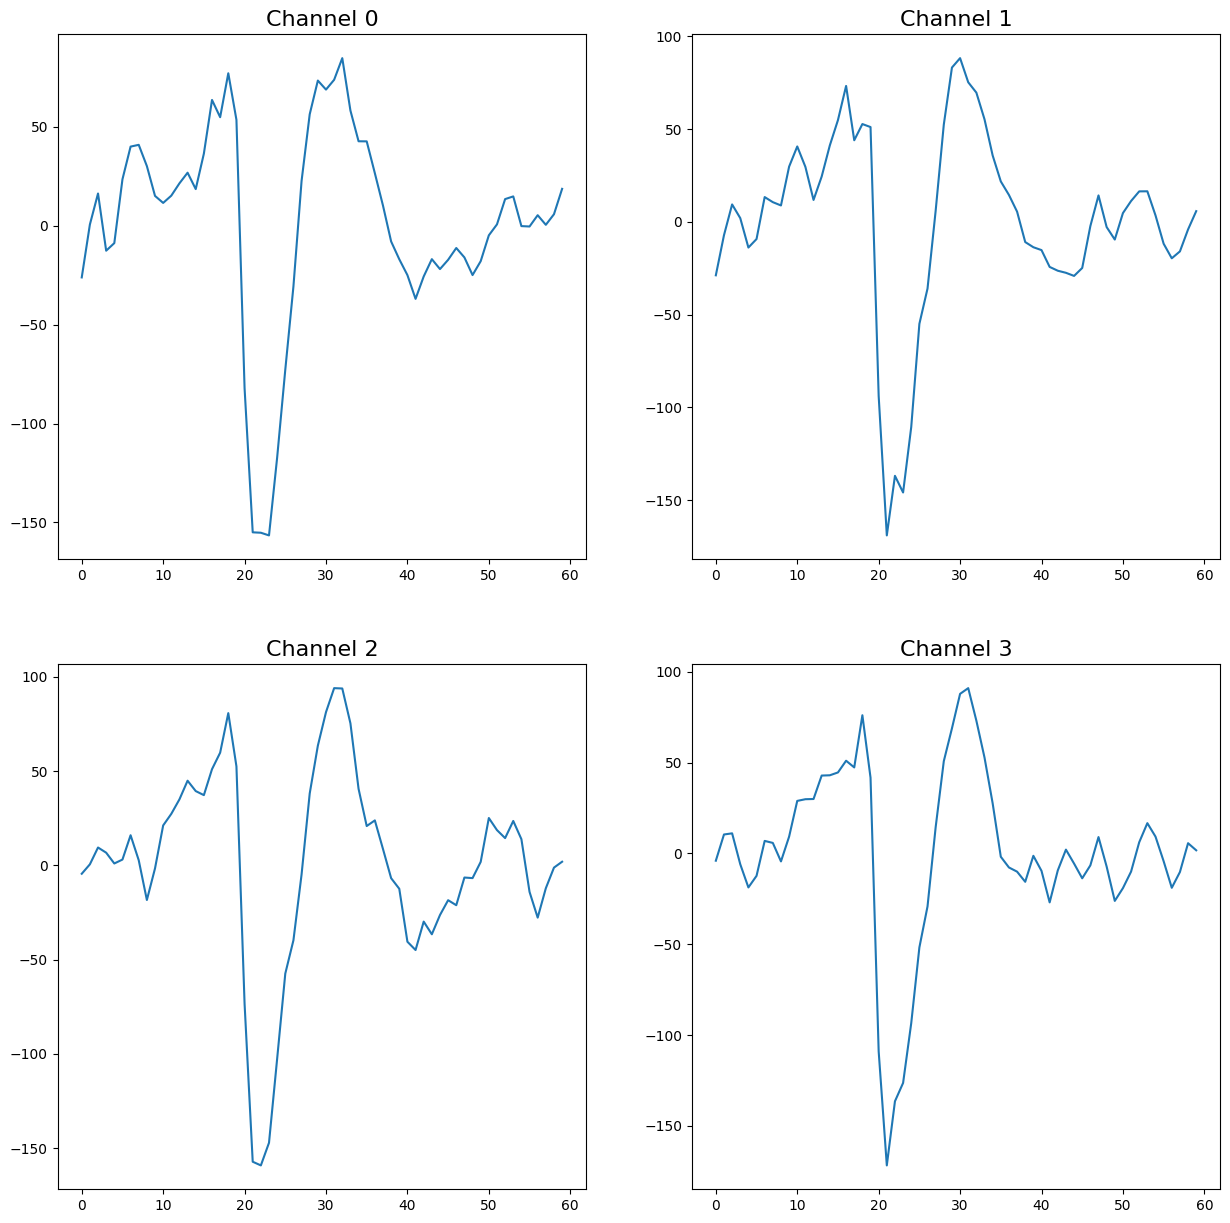

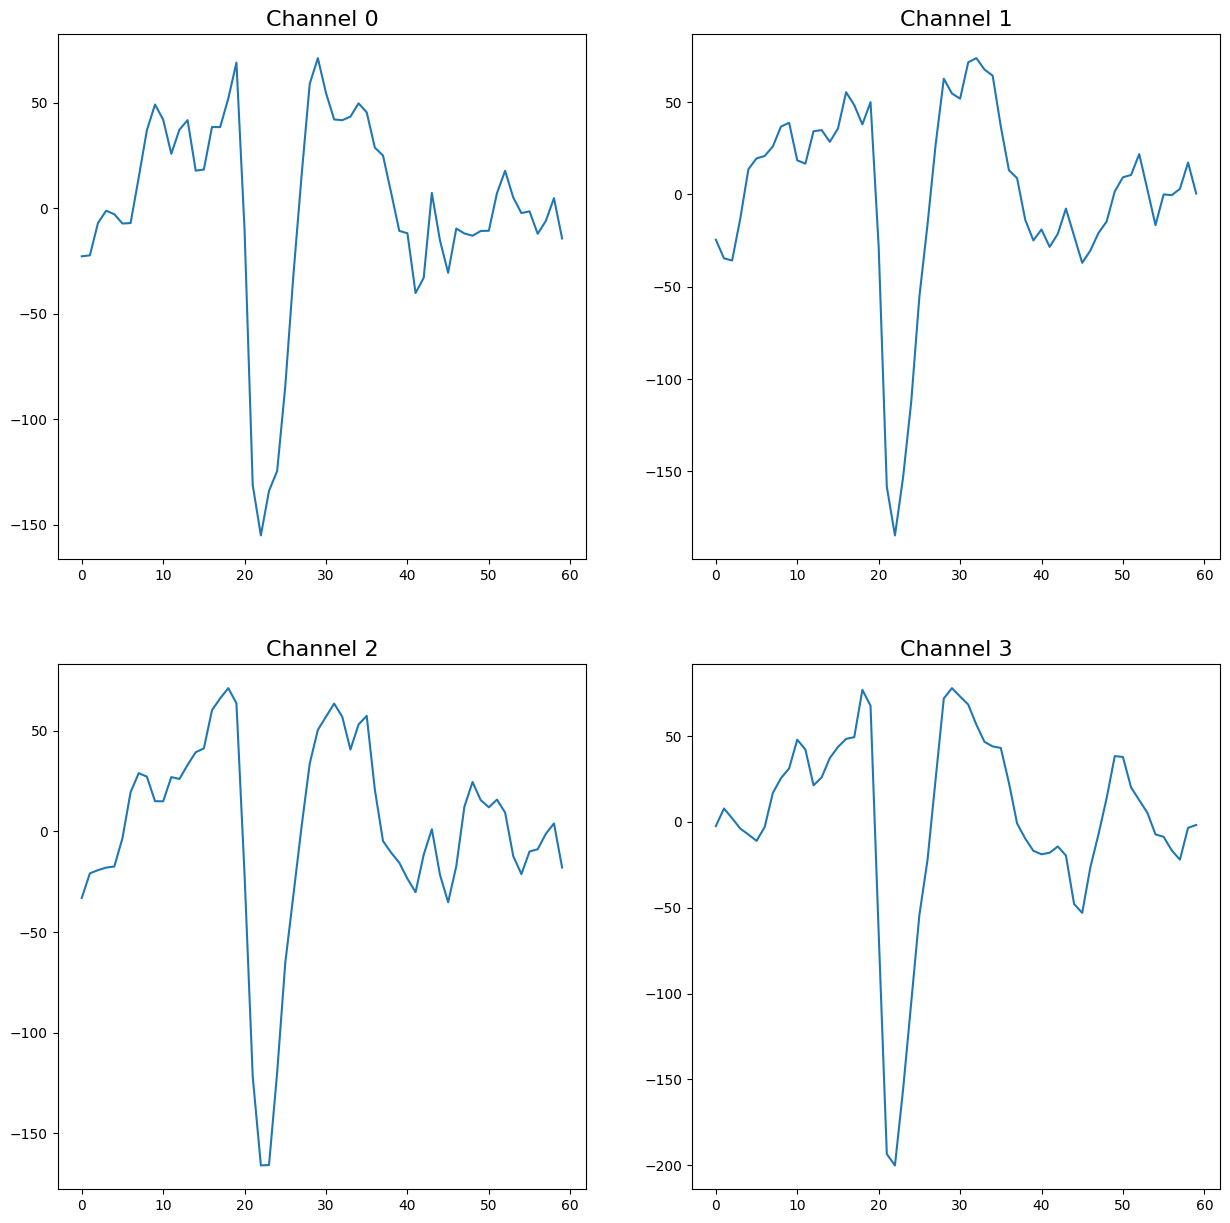

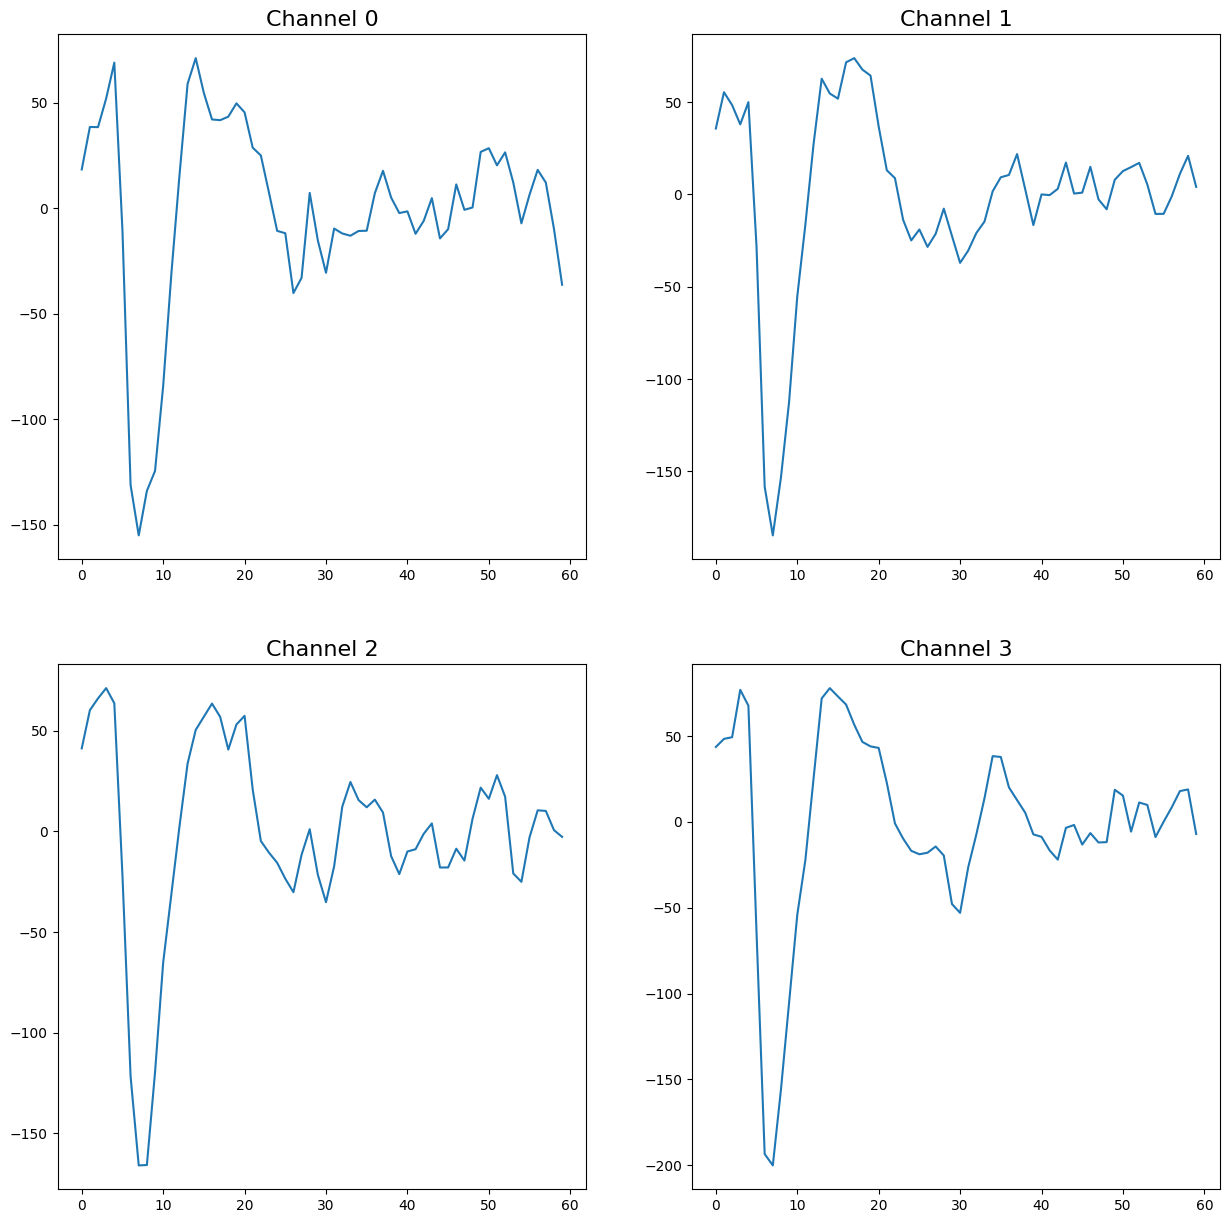

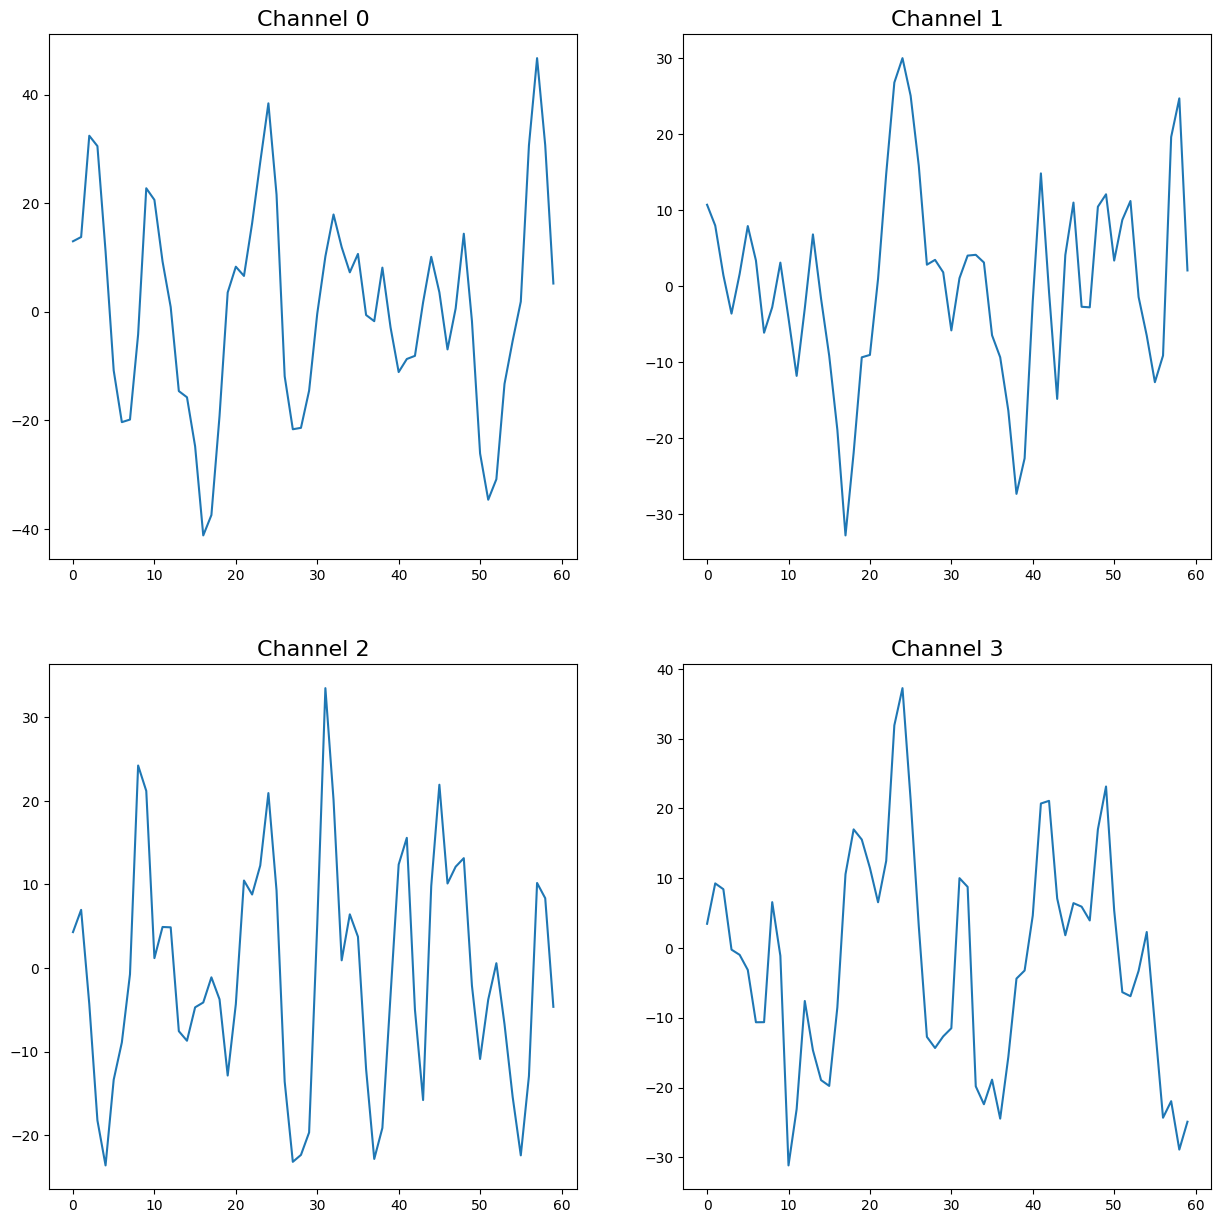

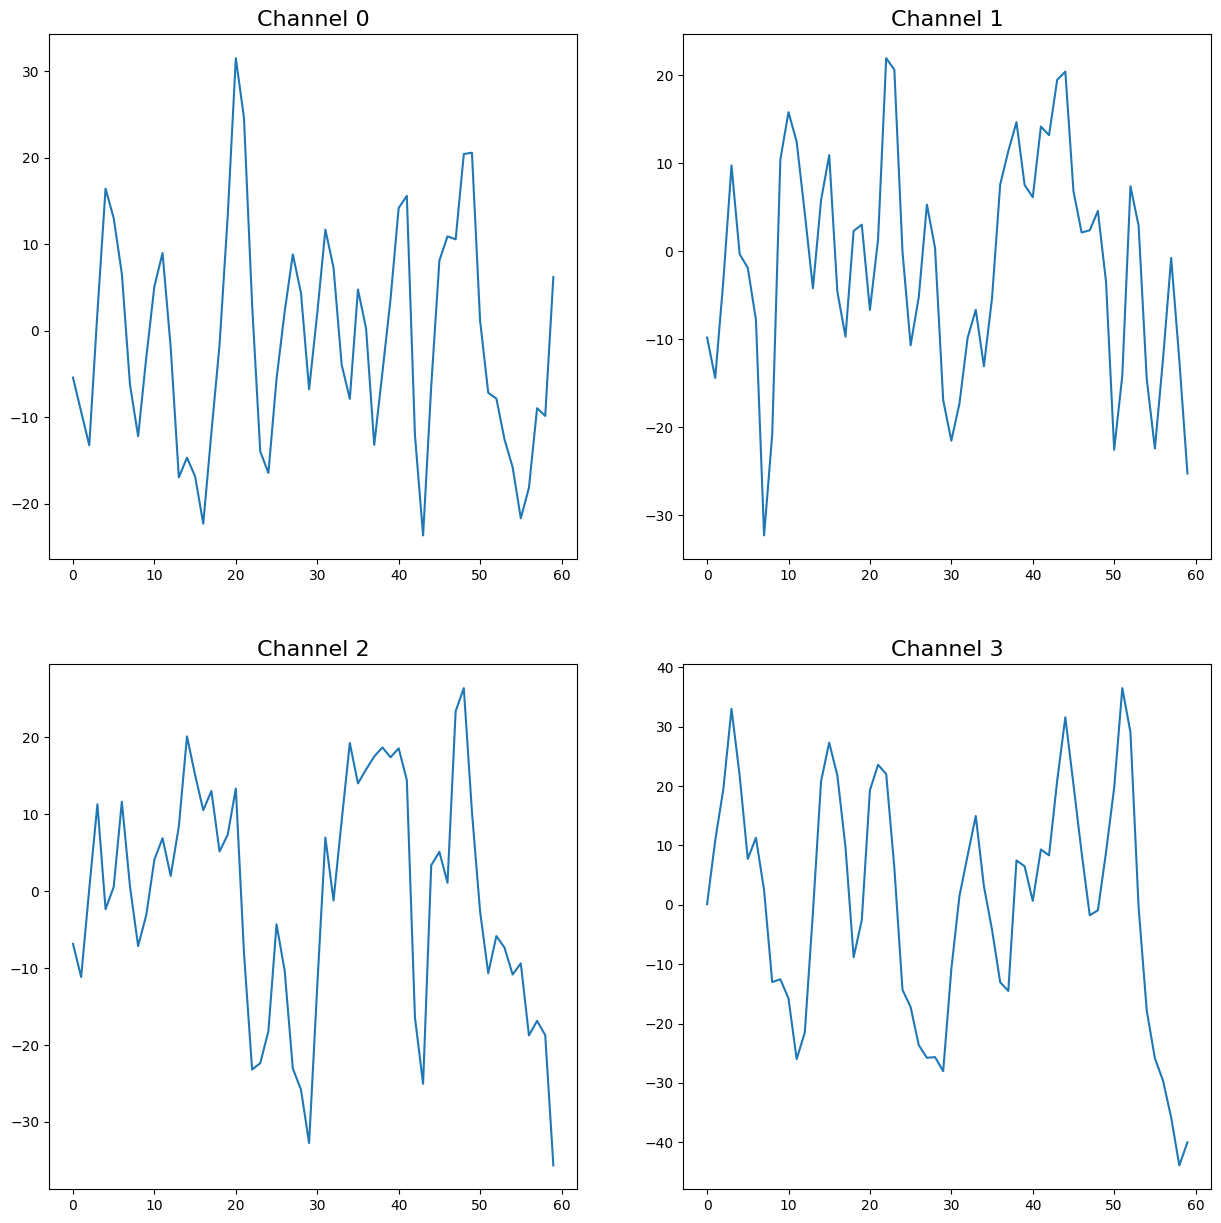

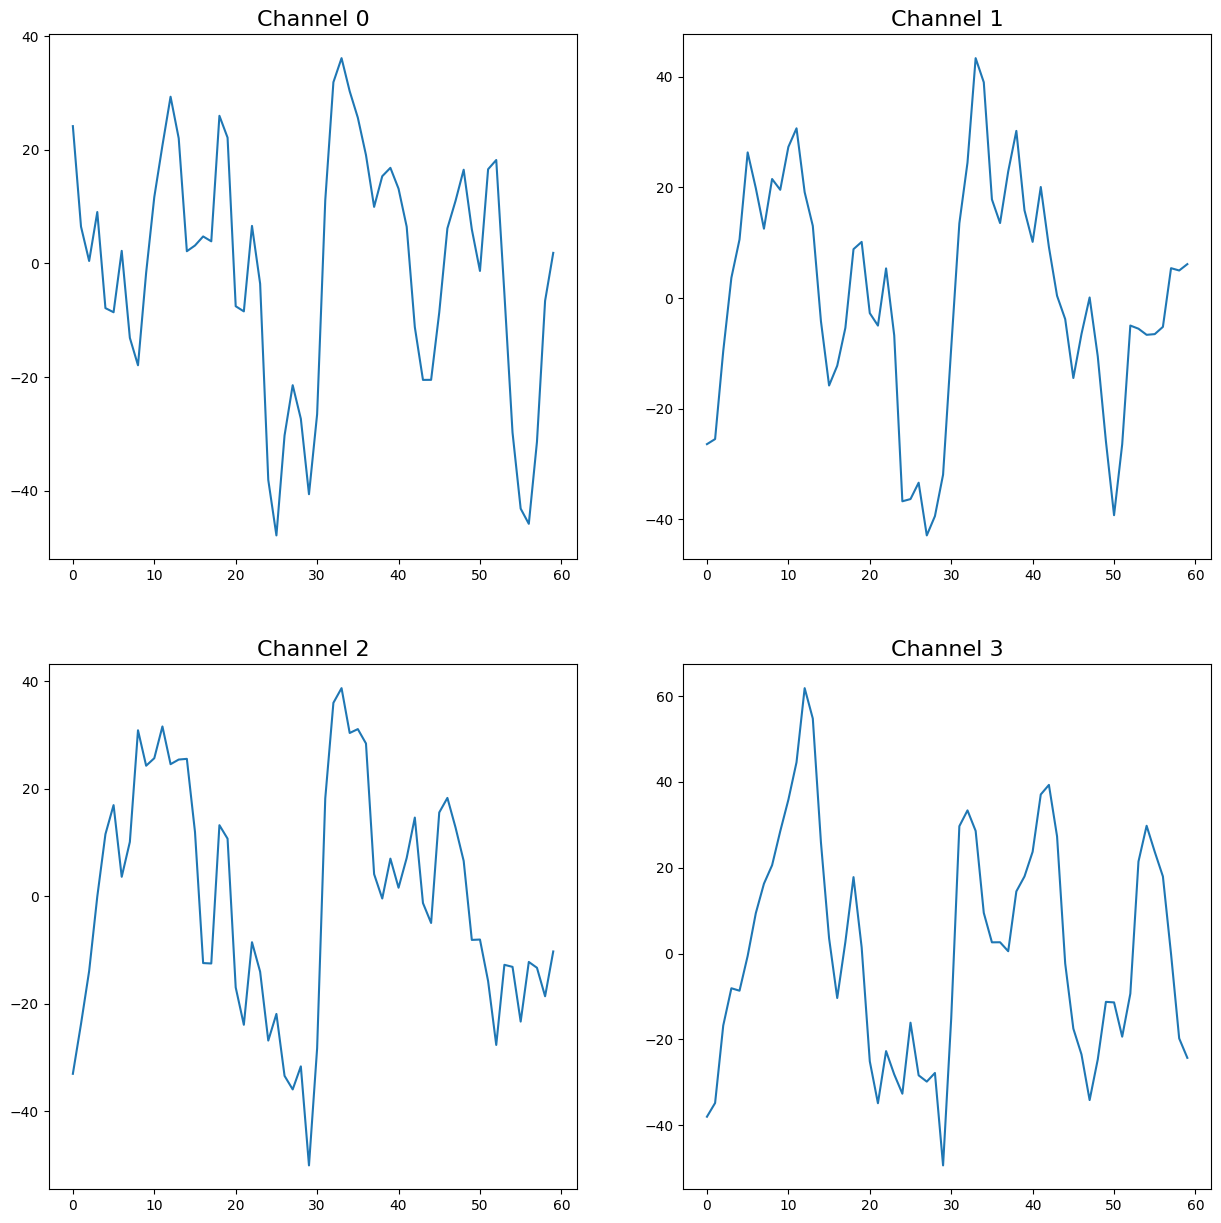

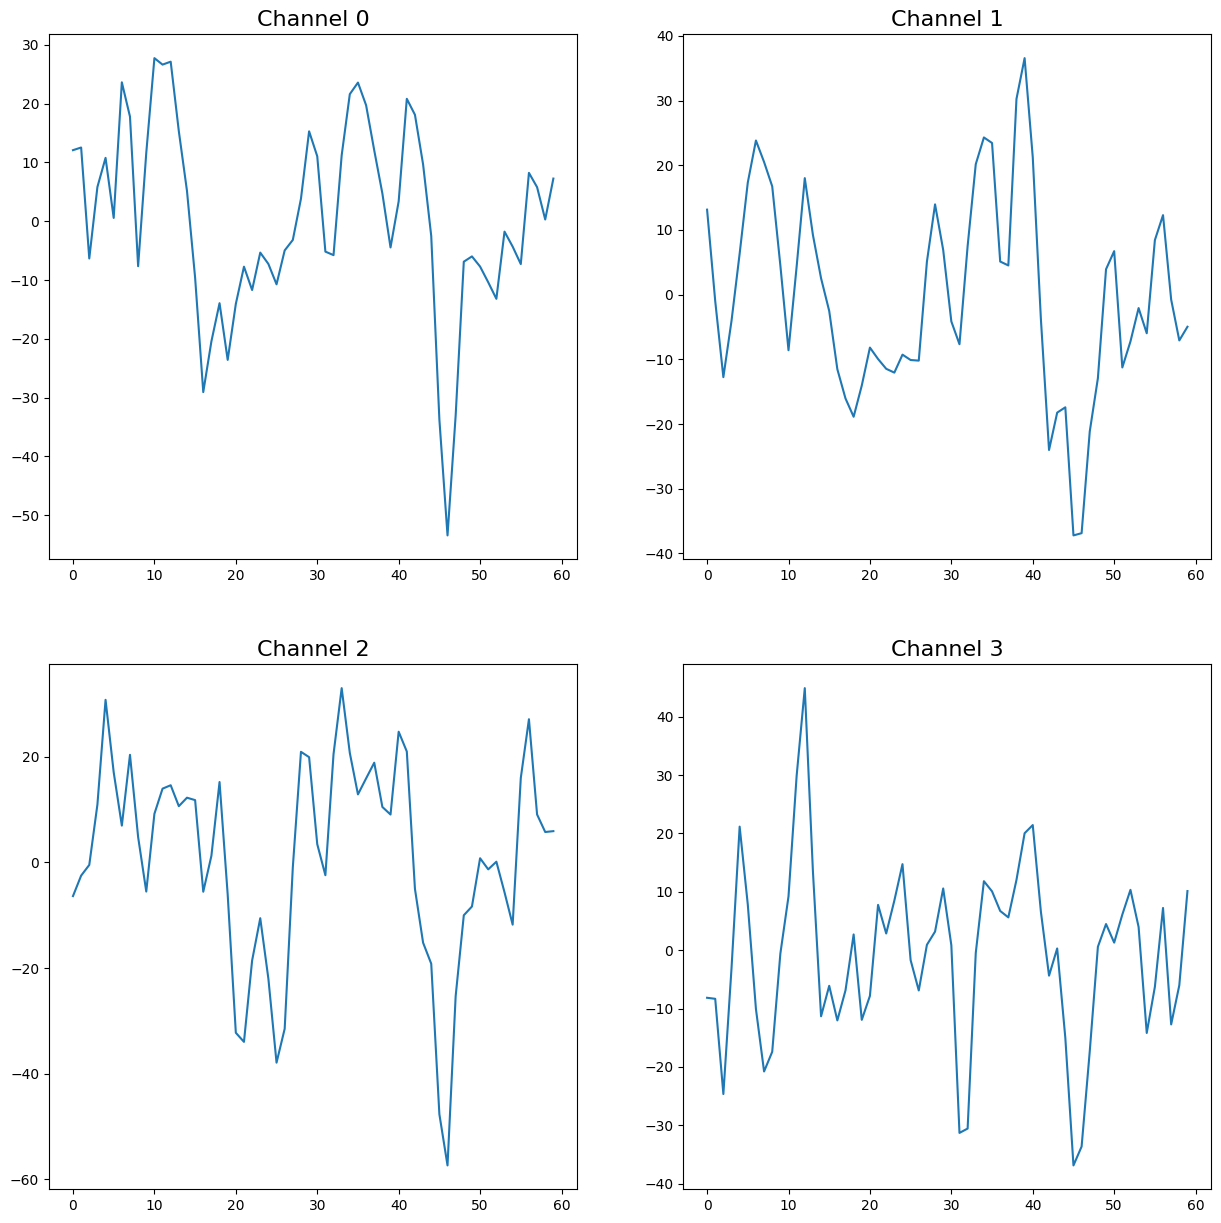

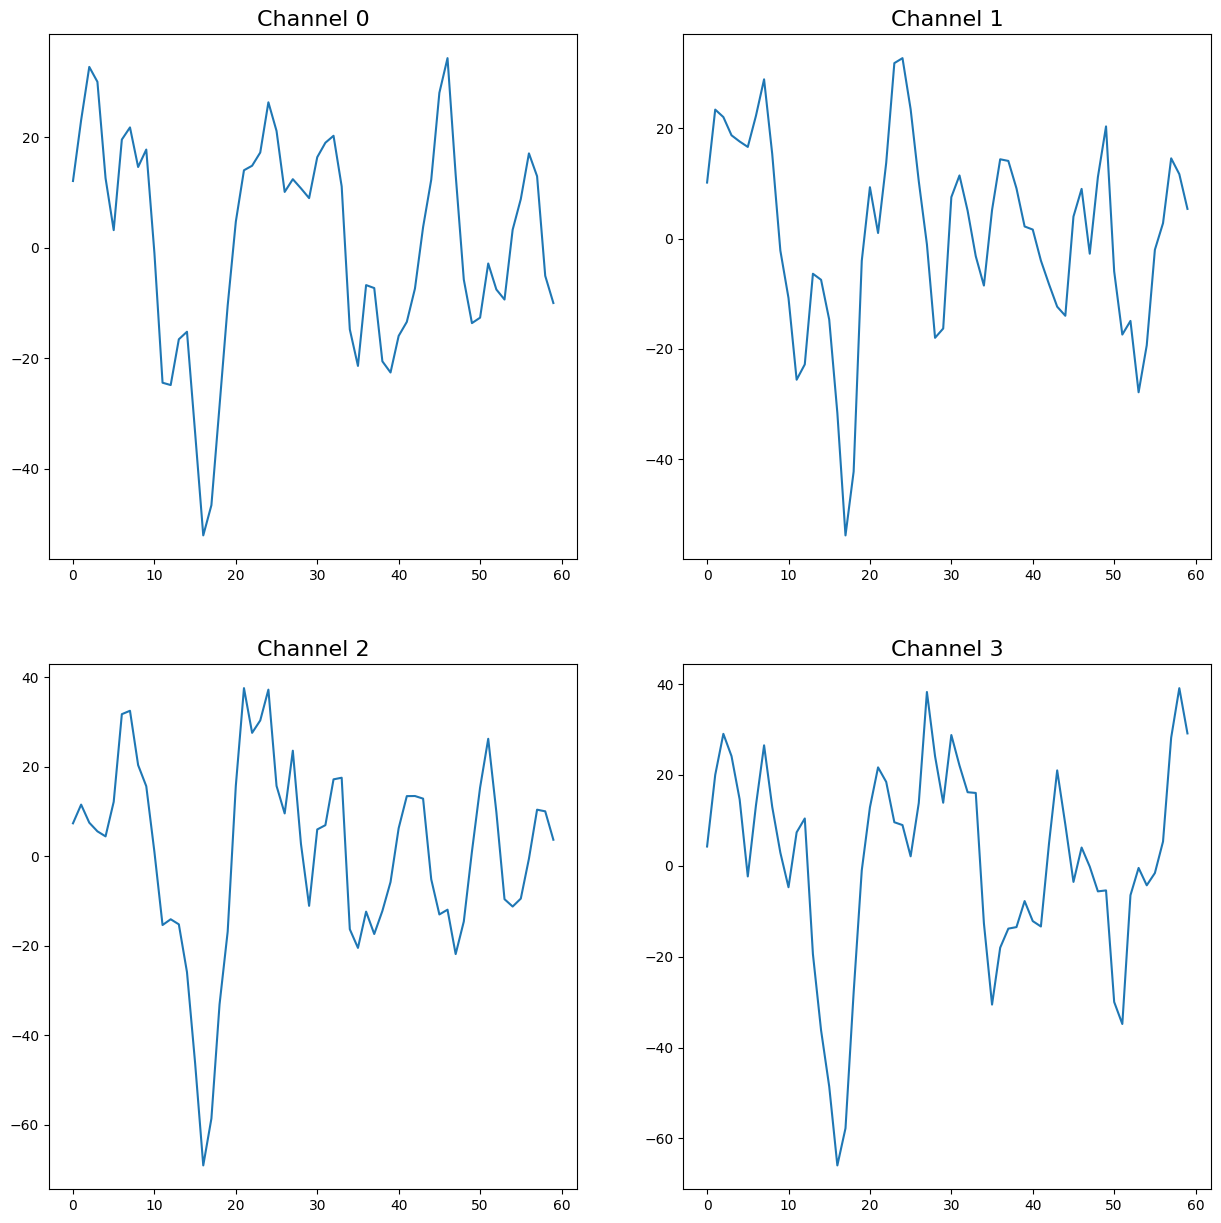

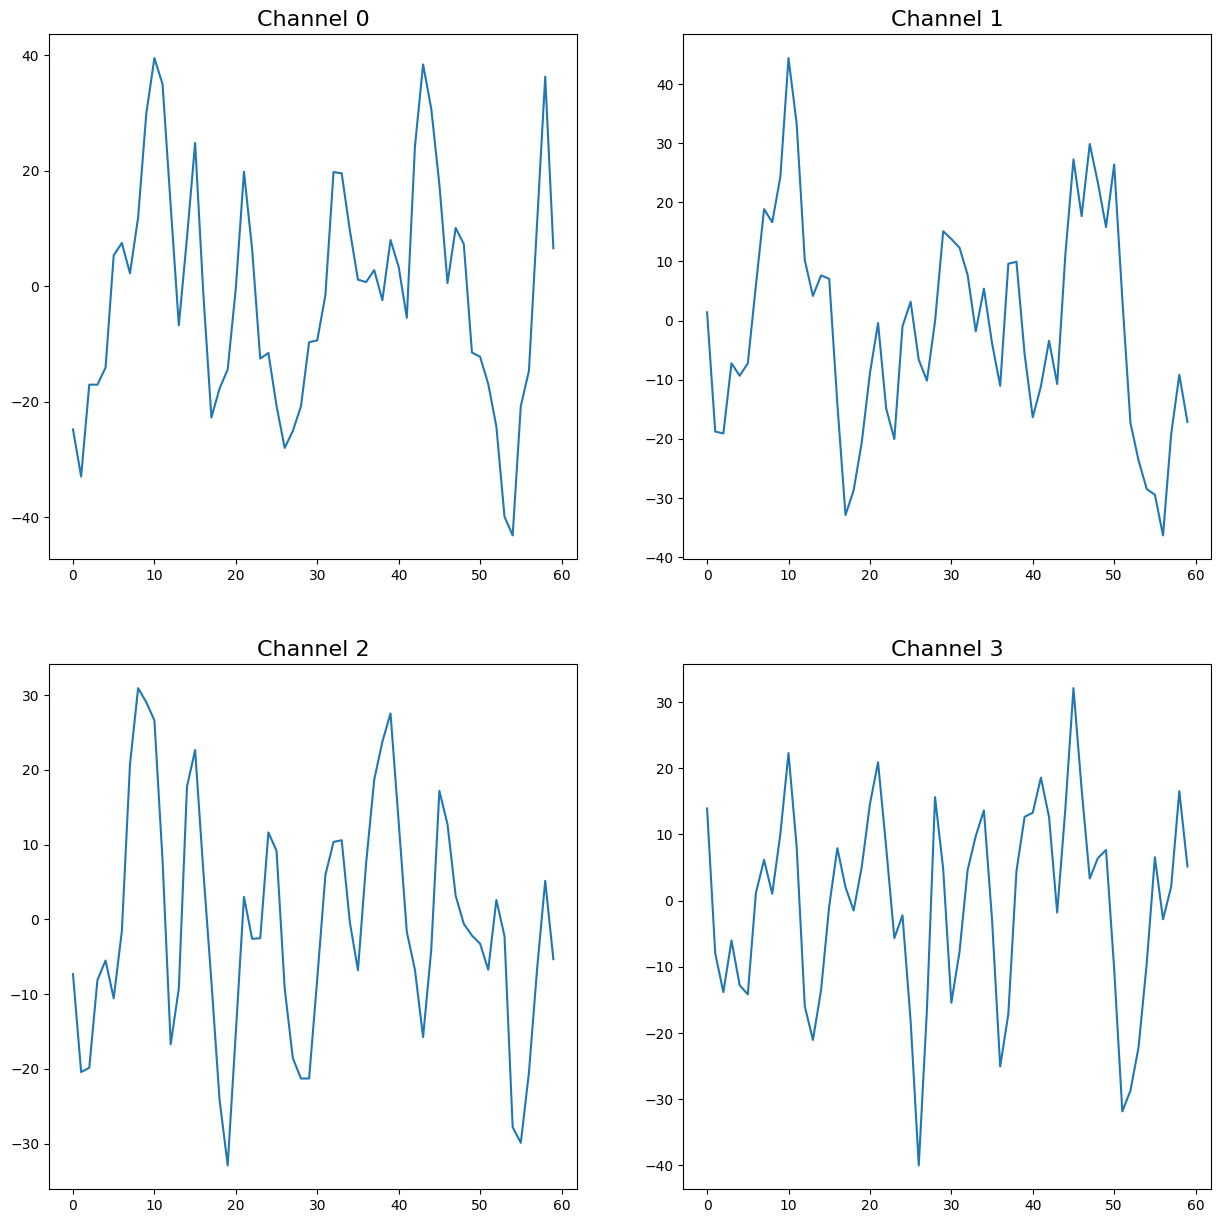

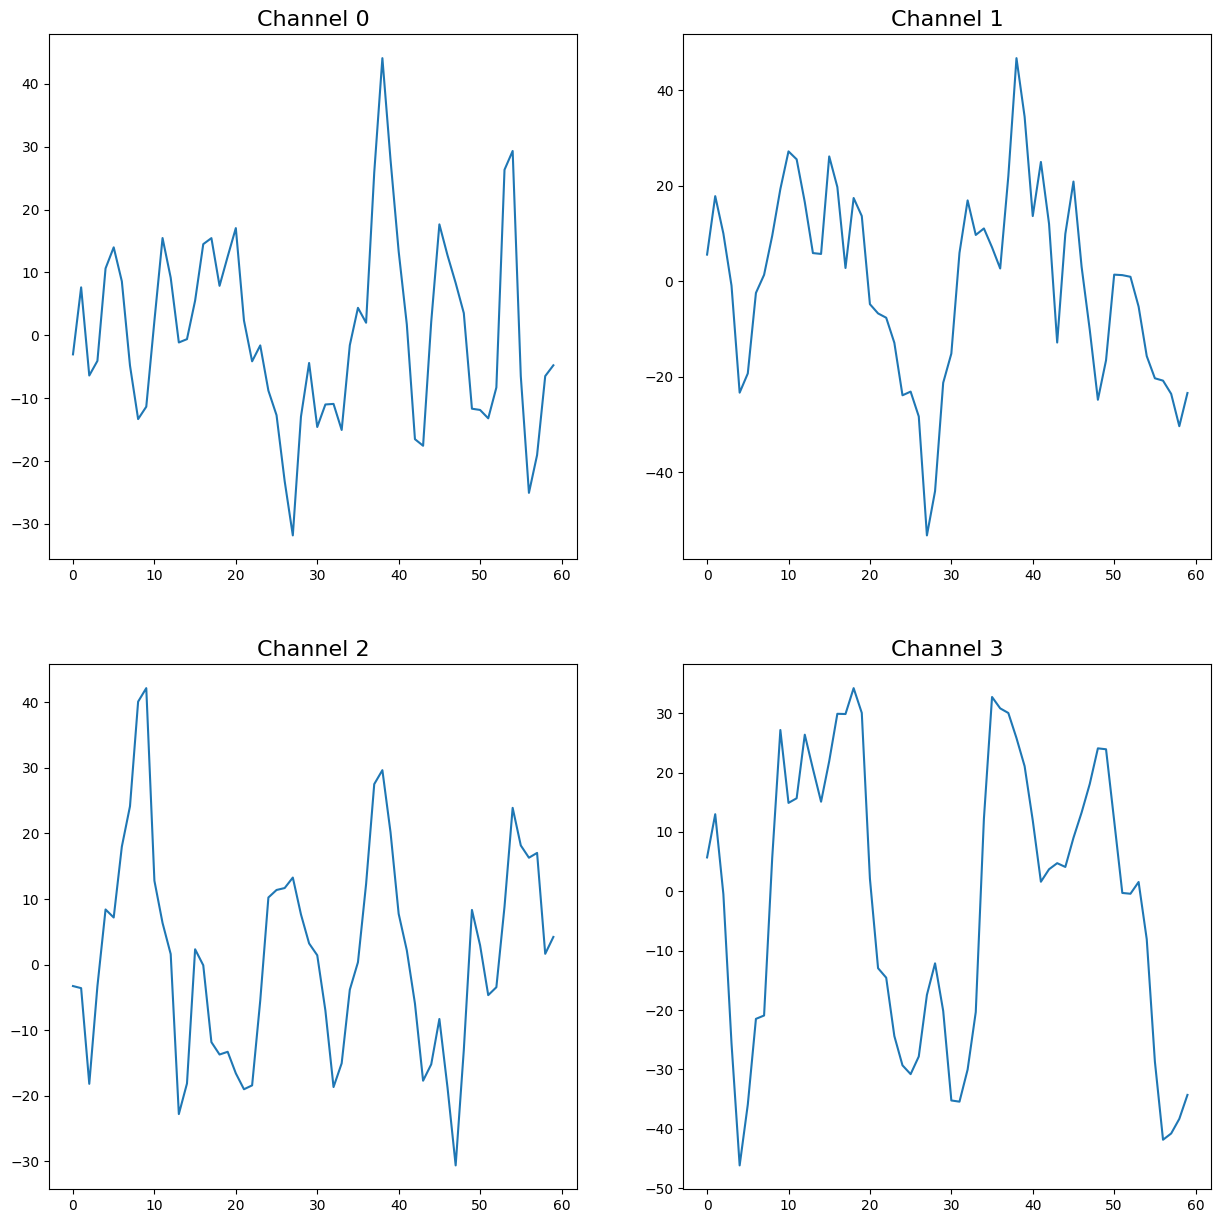

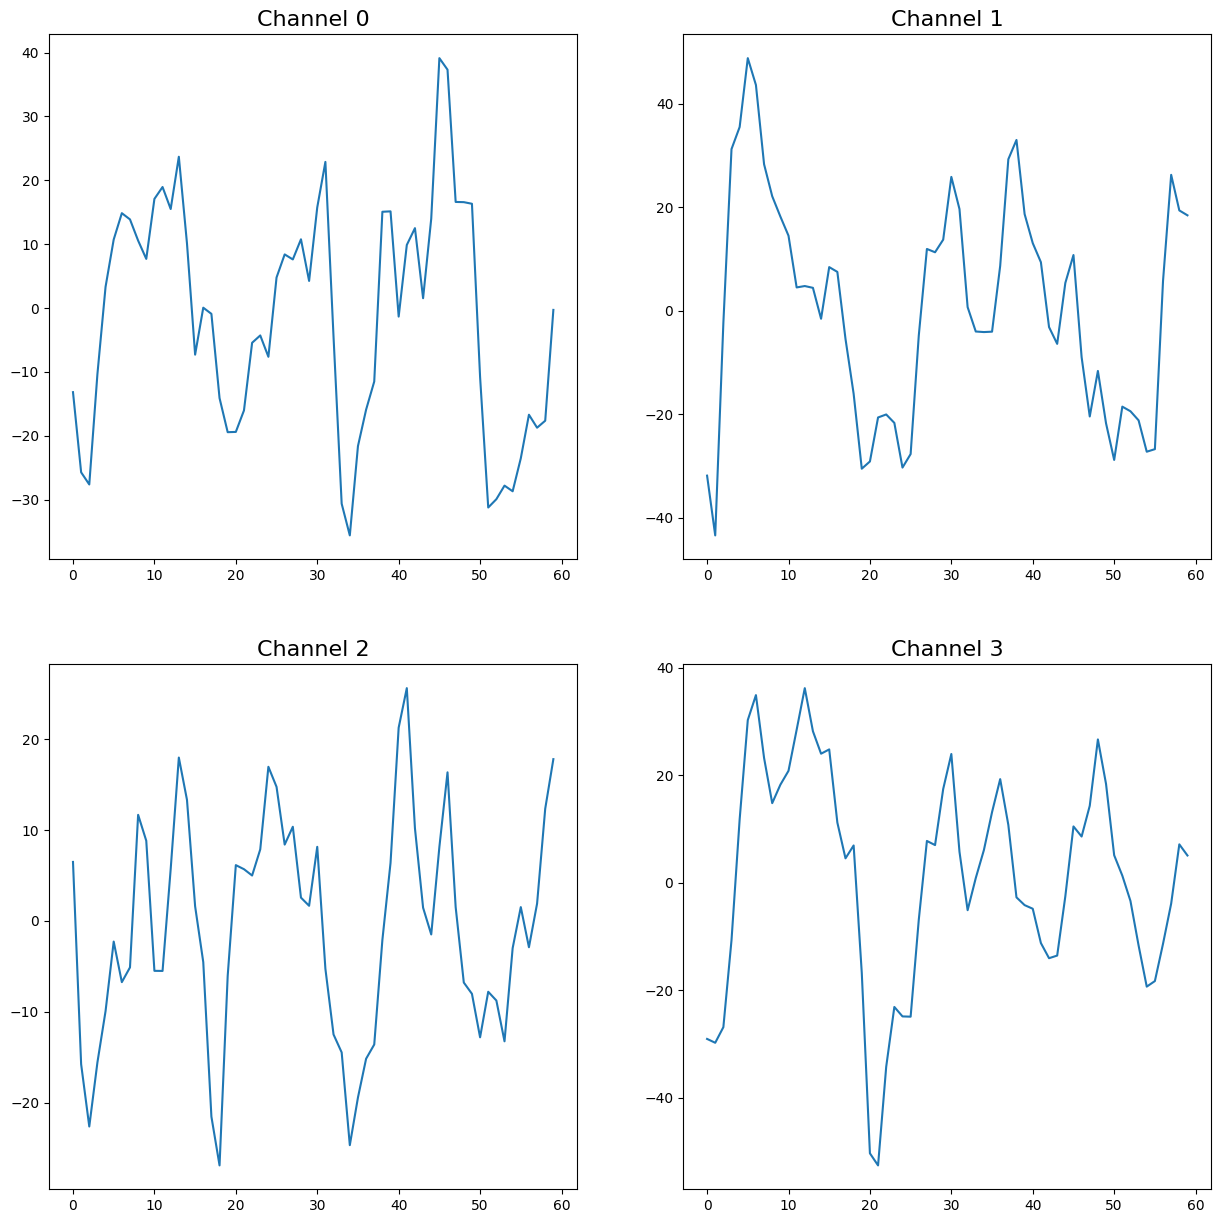

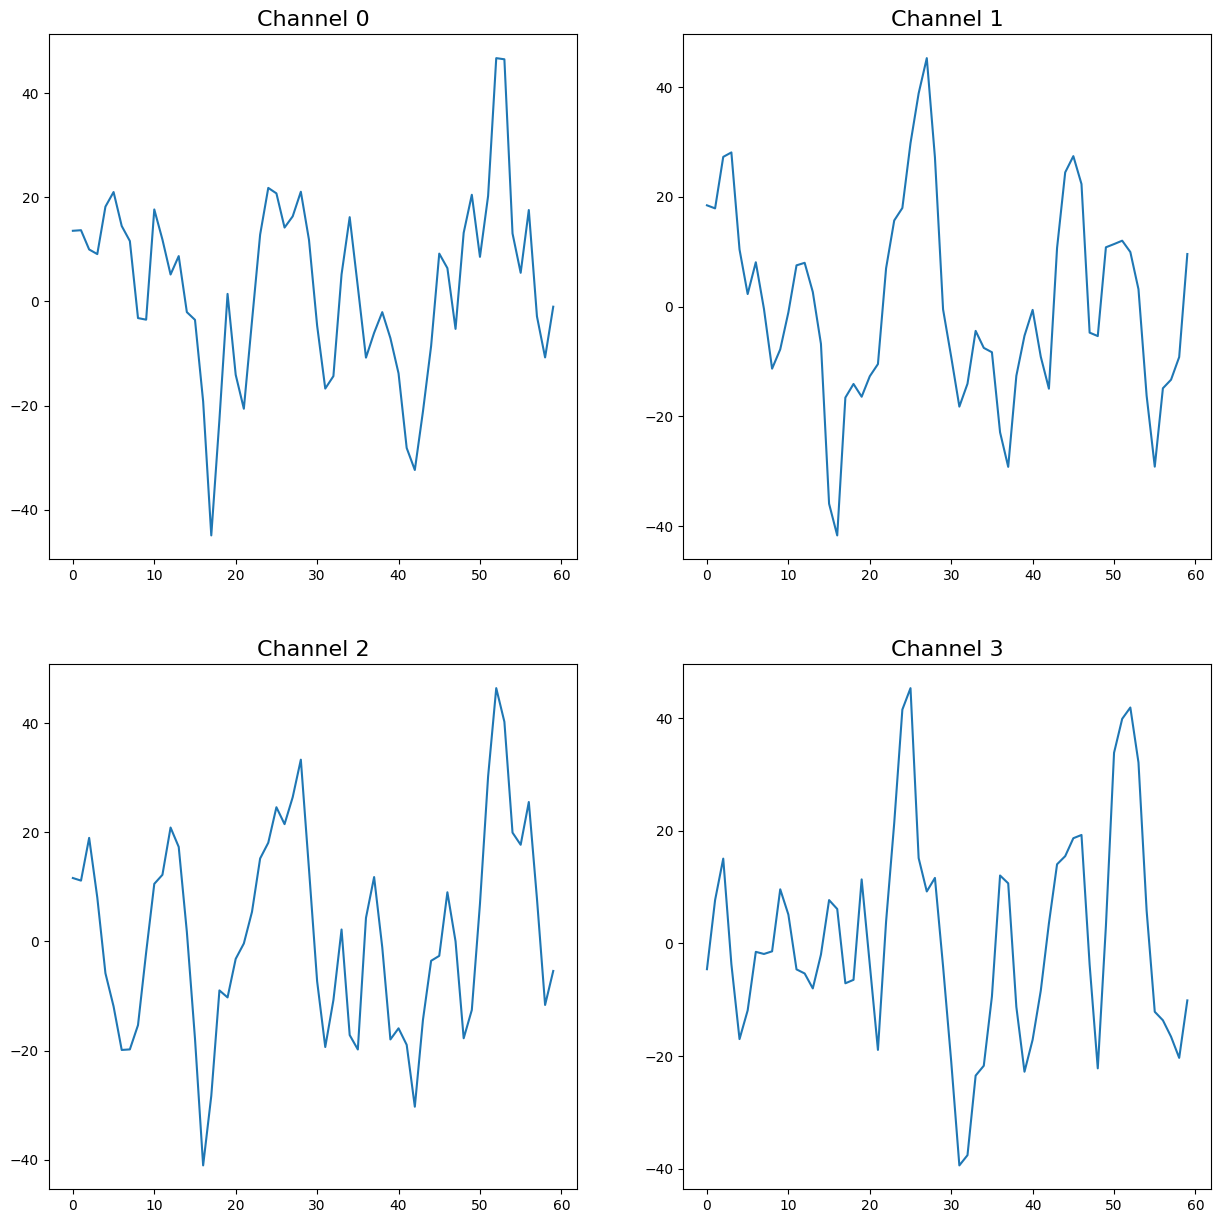

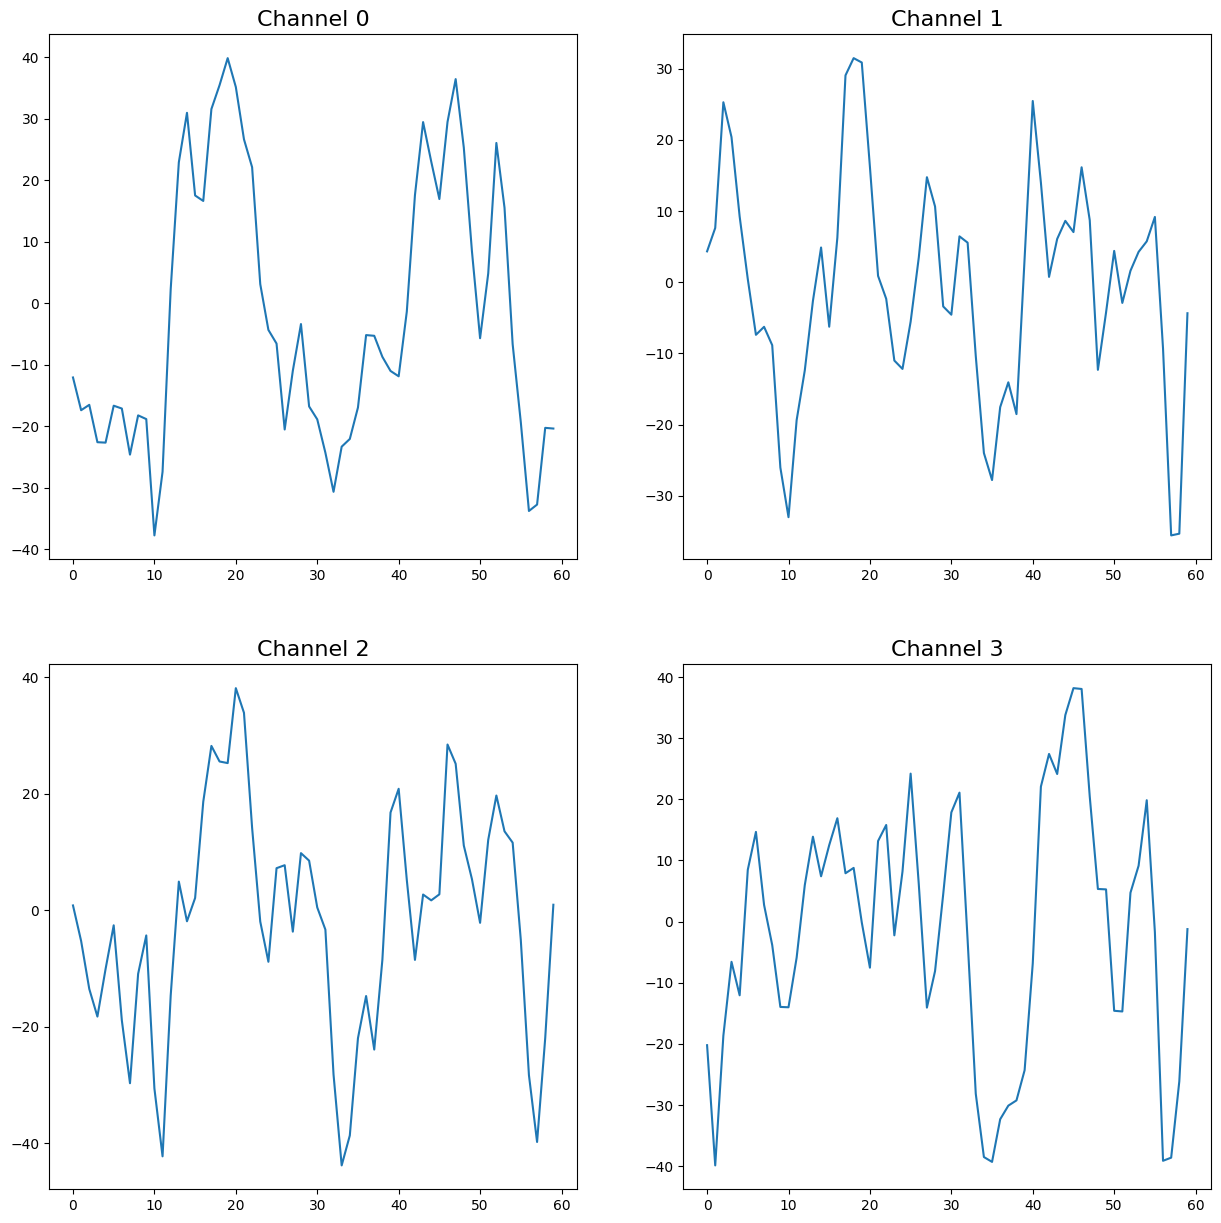

In [20]:
t_noise = 600 # start of background signal region


# Plot spikes
# for j in range(len(spike_intervals)):
for j in range(10):
    plt.figure(figsize=(15, 15))
    # plt.suptitle('Spike ' + str(j))
    for i in range(AP1.shape[1]):
        plt.subplot(2,2,i+1)
        plt.title('Channel ' + str(i))
        plt.plot(AP1[spike_intervals[j][0]:spike_intervals[j][1],i])

# Plot bg signal
# for j in range(len(spike_intervals)):
for j in range(10):
    plt.figure(figsize=(15, 15))
    # plt.suptitle('Noise ' + str(j))
    for i in range(AP1.shape[1]):
        plt.subplot(2,2,i+1)
        plt.title('Channel ' + str(i))
        plt.plot(AP1[pp*j+t_noise:pp*(j+1)+t_noise,i])

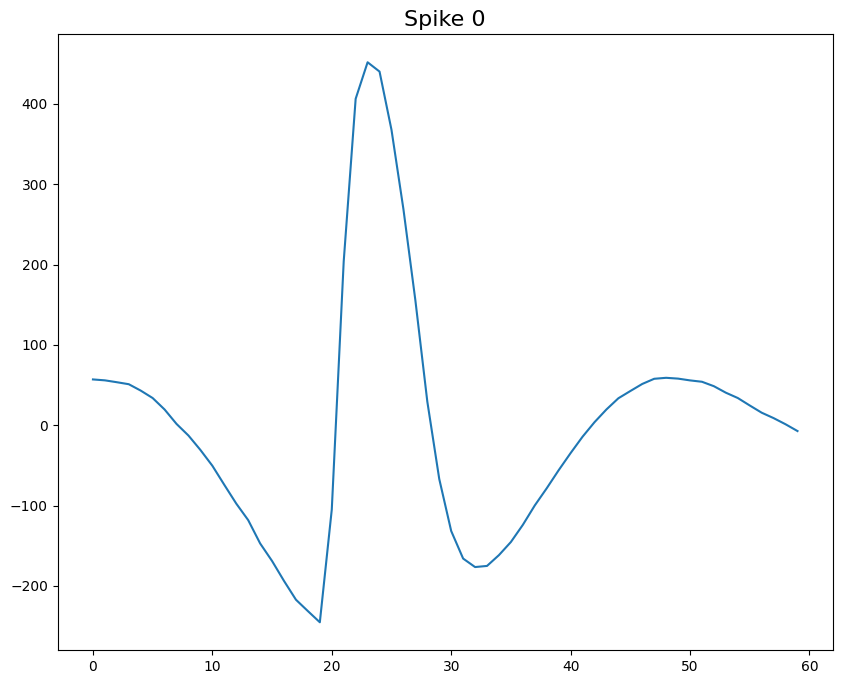

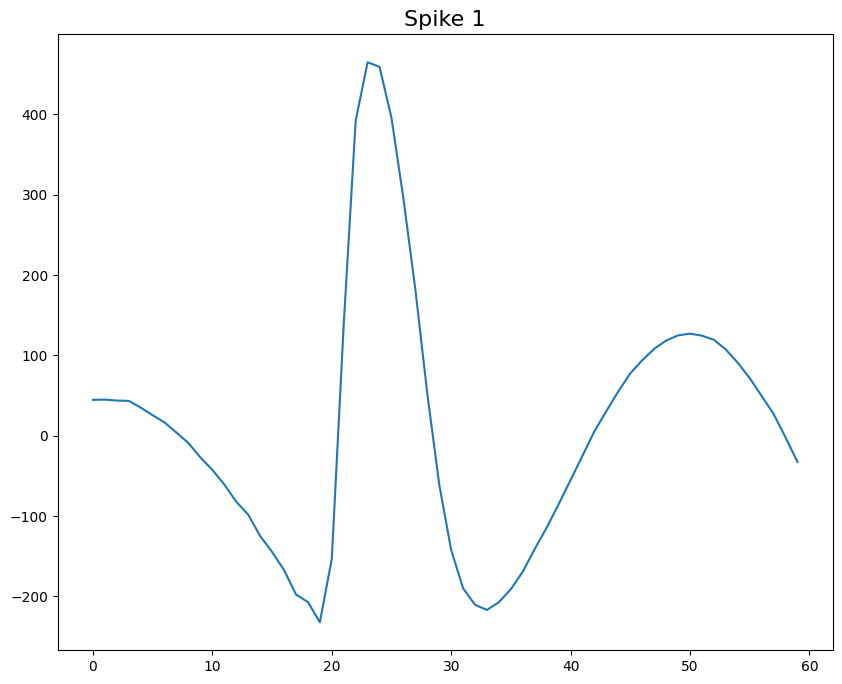

In [8]:
#Plot intracellular spikes
# for j in range(len(spike_intervals)):
for j in range(2):
    plt.figure(figsize=(10, 8))
    plt.title('Spike ' + str(j))
    plt.plot(AP_intra[spike_intervals[j][0]:spike_intervals[j][1],0])

### Plot for front page

(-5.45, 114.45, -167.33289227894073, 84.6625097240953)

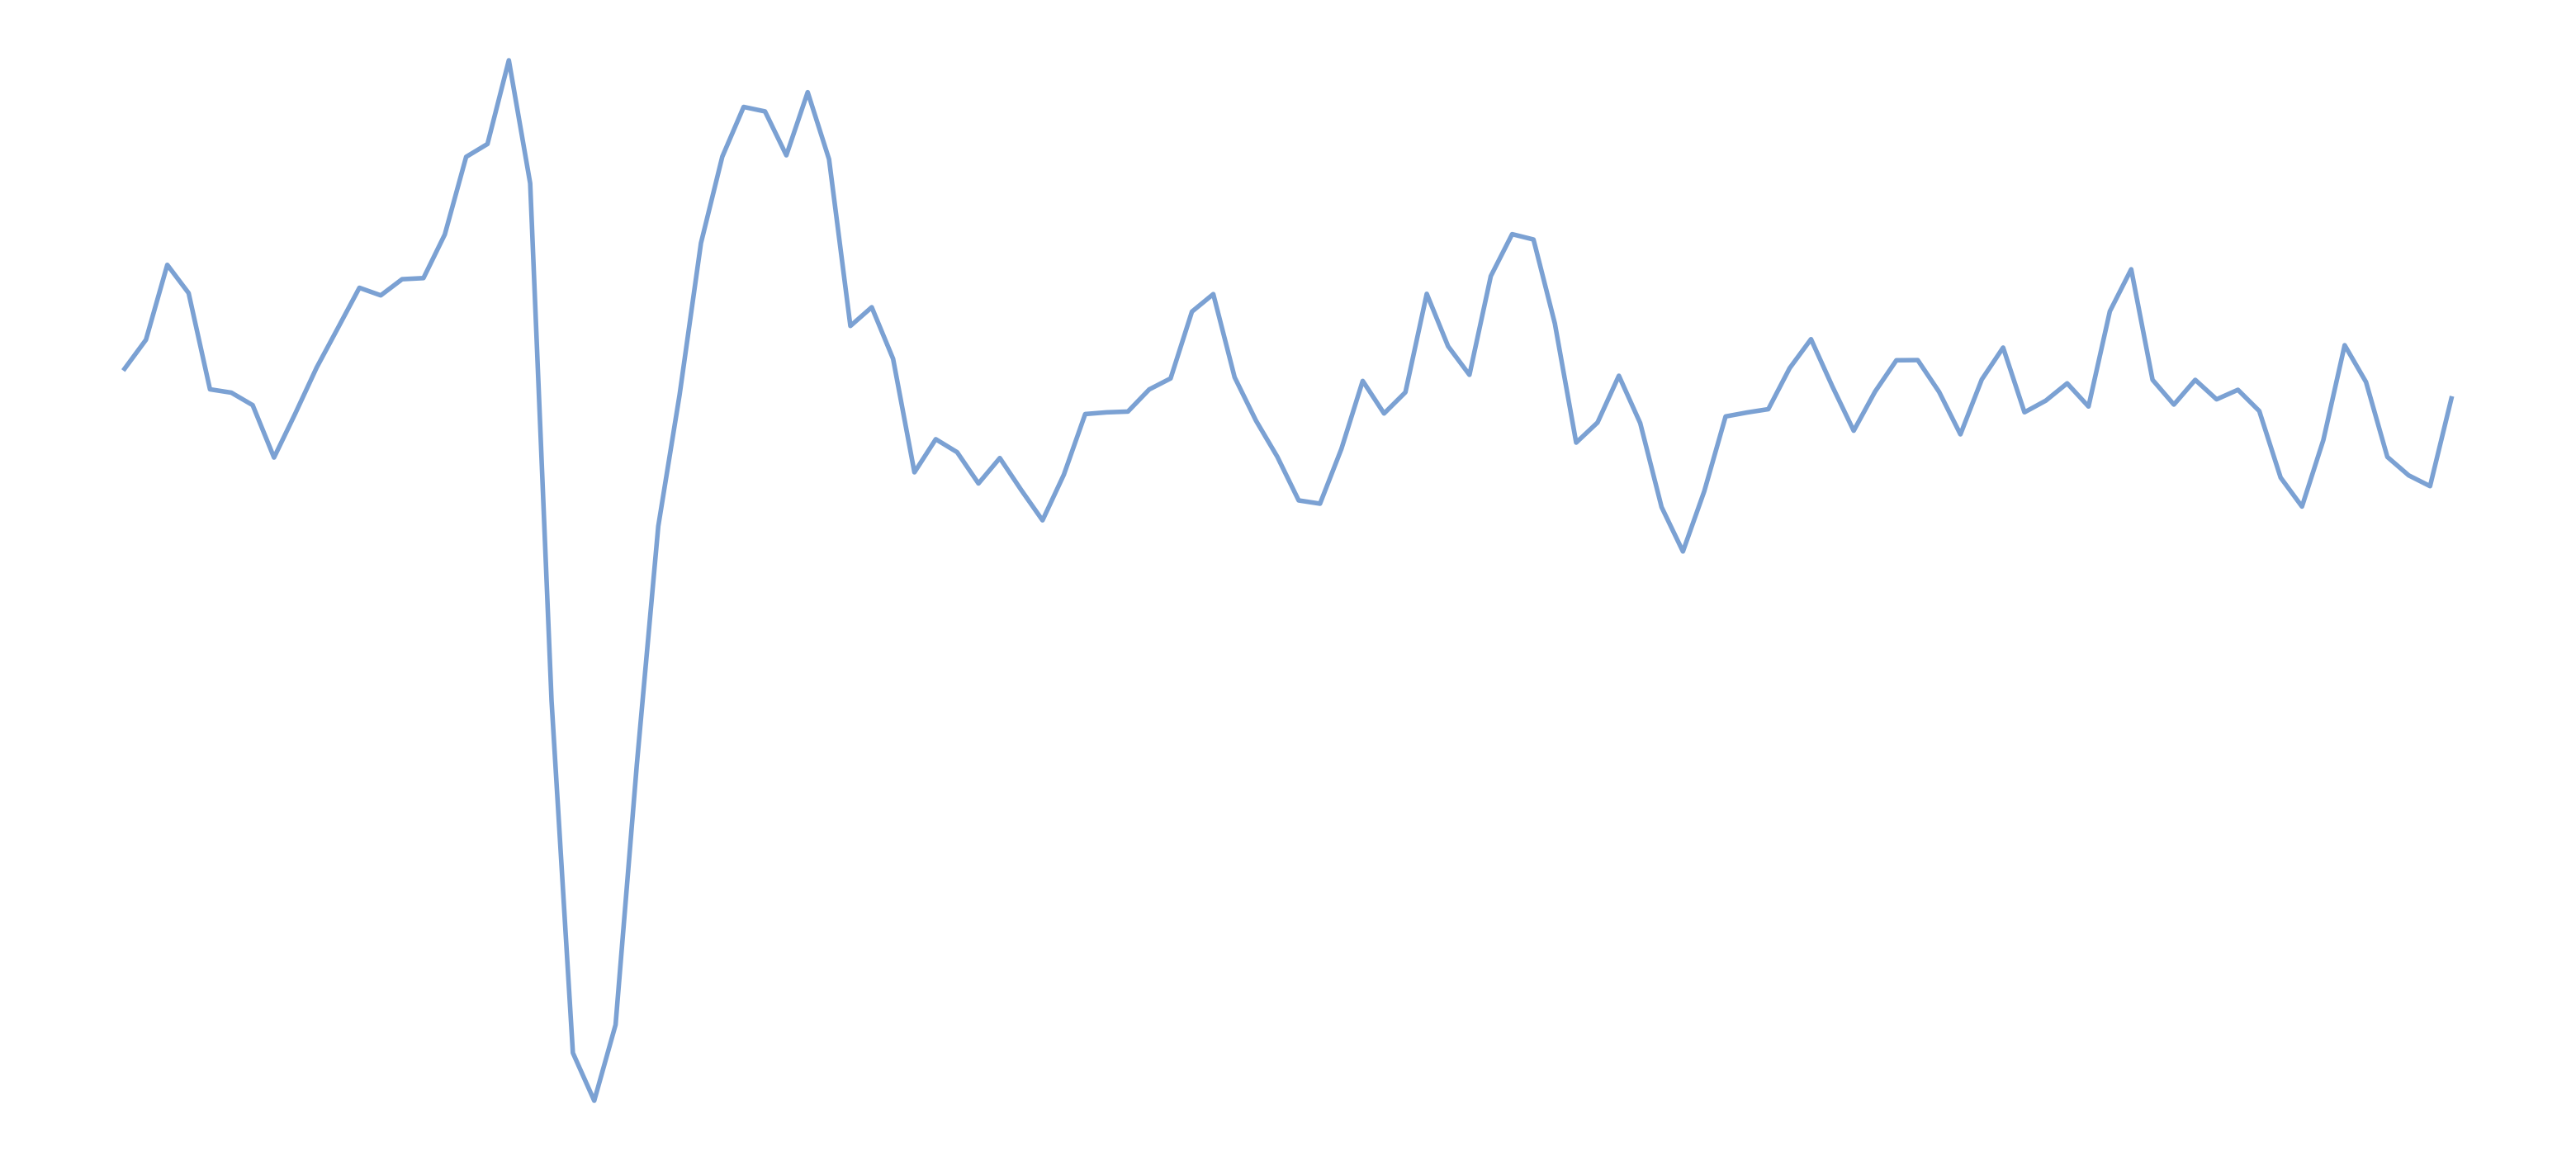

In [32]:
# plot for front page

# plt.figure(figsize=(20,10))
# plt.plot(AP1[spike_intervals[0][0]:spike_intervals[0][1]+50,0], color='#7BA1D3', linewidth=3.0)
# plt.axis("off")

plt.figure(figsize=(40,18))
plt.plot(AP1[spike_intervals[0][0]:spike_intervals[0][1]+50,0], color='#7BA1D3', linewidth=4.0)
plt.axis("off")
# plt.figure(figsize=(20,10))
# plt.plot(AP1[spike_intervals[0][0]-50:spike_intervals[0][1]+5,0], color='#7BA1D3', linewidth=3.0)
# plt.axis("off")
# plt.figure(figsize=(20,10))
# plt.plot(AP1[spike_intervals[0][0]-30:spike_intervals[0][1]+5,0], color='#7BA1D3', linewidth=3.0)
# plt.ylim(-167.33289227894073, 300)
# plt.axis("off")

### Estimate spike SNR

SNR: 1.04 dB


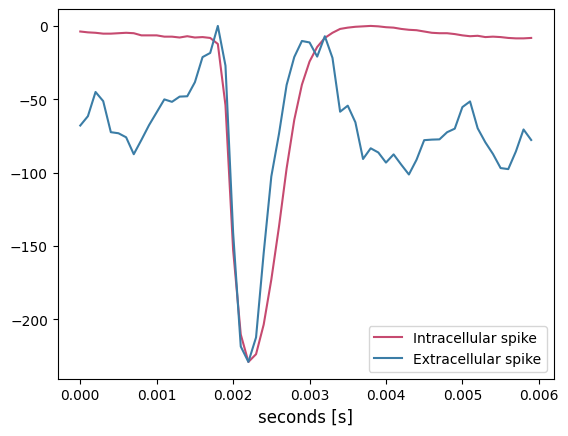

In [10]:
# plot for Dataset section + SNR estimate

spike_in = s_intra[spike_intervals[0][0]+1:spike_intervals[0][1]+1] - np.min(s_intra[spike_intervals[0][0]:spike_intervals[0][1]]) #s_intra[spike_intervals[0][0]]
spike_ex = AP1[    spike_intervals[0][0]:spike_intervals[0][1],0] - np.max(AP1[    spike_intervals[0][0]:spike_intervals[0][1],0])

spike_in_scaled = -spike_in/np.max(np.abs(spike_in))*np.max(np.abs(spike_ex))


plt.figure()
# plt.plot(ts[:spike_in_scaled.shape[0]],-spike_in, color='#C64A70')
plt.plot(ts[:spike_in_scaled.shape[0]], spike_in_scaled, color='#C64A70')
plt.plot(ts[:spike_in_scaled.shape[0]], spike_ex, color='#3B7DA6')
plt.xlabel('seconds [s]', fontsize=12)
plt.legend(['Intracellular spike', 'Extracellular spike'])


P_d = np.linalg.norm(spike_in_scaled)
P_error = np.linalg.norm((spike_in_scaled - spike_ex))
SNDR_intra = 20*np.log10(P_d/P_error)
print(f'SNR: {SNDR_intra:.2f} dB')

### Visualize DCT coeffs

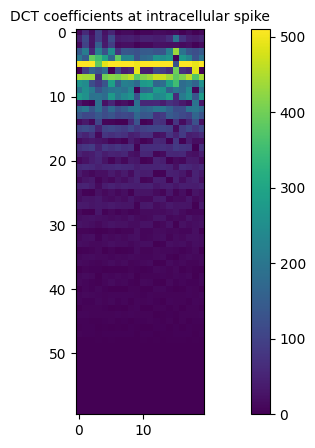

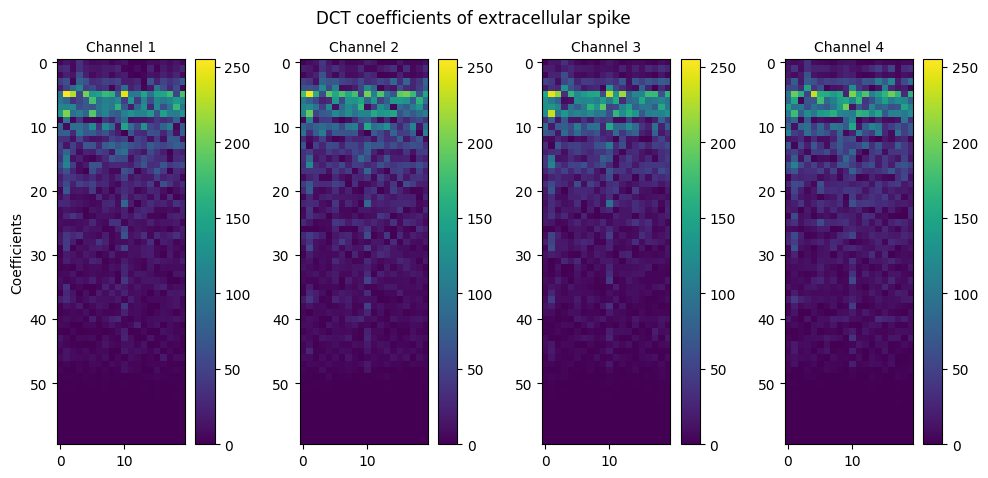

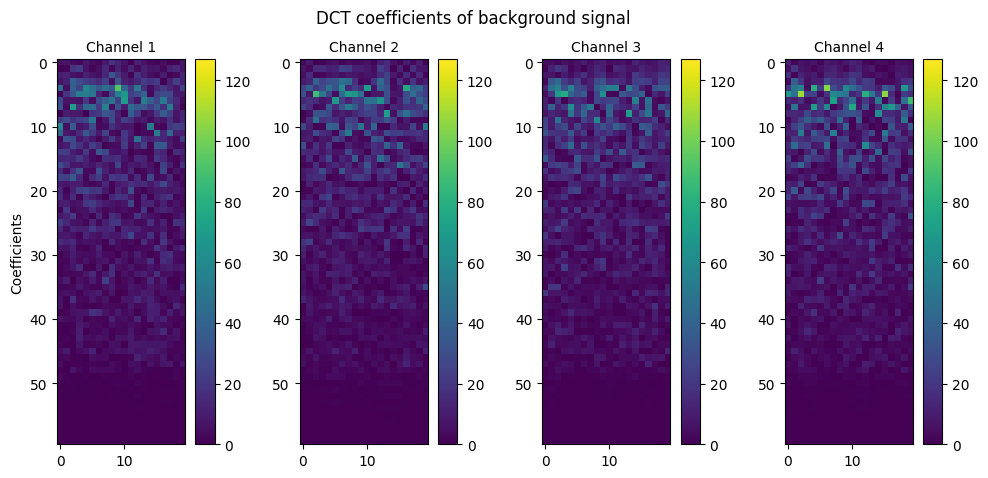

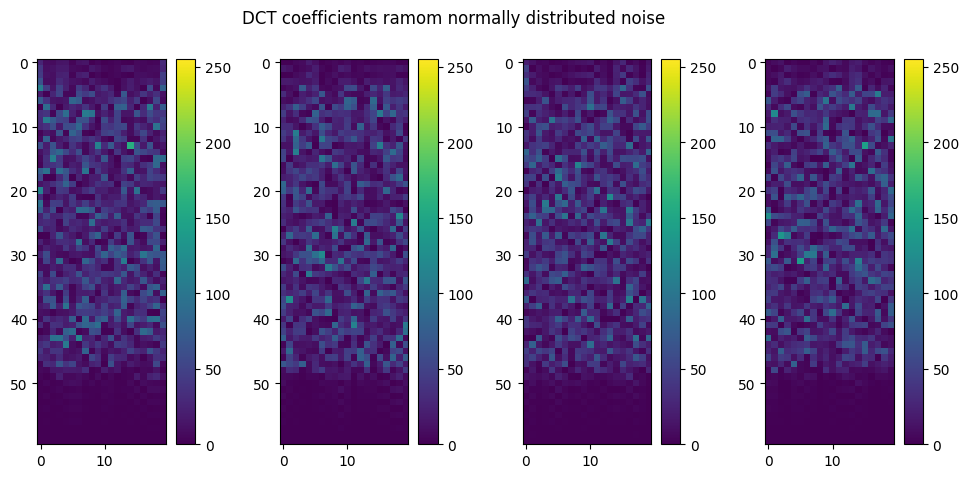

In [11]:
# make array of intracellular spikes
c_mat_spike_in = getDCT(AP_intra[spike_intervals[0][0]:spike_intervals[0][1],:] )
for i in range(1,n_spikes):
    temp = getDCT(AP_intra[spike_intervals[i][0]:spike_intervals[i][1],:])
    c_mat_spike_in = np.concatenate((c_mat_spike_in, temp), axis=1)


# make array of extracellular spikes
c_mat_spike = getDCT(AP1[spike_intervals[0][0]:spike_intervals[0][1], :N_ch])
for i in range(1,n_spikes):
    temp = getDCT(AP1[spike_intervals[i][0]:spike_intervals[i][1], :N_ch])
    c_mat_spike = np.concatenate((c_mat_spike, temp), axis=1)

# make array of background signal
c_mat_noise = getDCT(AP1[t_noise:pp*n_spikes + t_noise, :N_ch]) #pick out region for background siganl

# get min and max values to have plots on the same scale
c_max = np.max([abs(c_mat_spike),abs(c_mat_noise)])
c_min = np.min([abs(c_mat_spike),abs(c_mat_noise)])

# function to normalize each column of the dct coefficients
def visualize_dct(c):
    for i in range(c.shape[0]):
        c[i,:] = 255* (c[i,:] - c[i,:].min()) / (c_max - c_min)
    return c

# set font sizes for plots
plt.rc('font', size=10)         
plt.rc('axes', titlesize=10)    
plt.rc('axes', labelsize=10)    

# visulaize the DCT coefficients for intracellular spike
plt.figure(0, figsize=[12,5])
plt.title('DCT coefficients at intracellular spike')
plt.imshow(visualize_dct(abs(c_mat_spike_in[:,:,:]).T).T, vmin=0, vmax=510) 
plt.colorbar()

# visualize for extracellular spikes
plt.figure(1, figsize=[12,5])
plt.suptitle('DCT coefficients of extracellular spike')
for i in range(N_ch): 
    plt.subplot(1,4,i+1)
    plt.imshow(visualize_dct(abs(c_mat_spike[:,:,i]).T).T, vmin=0, vmax=255) 
    plt.title(f'Channel {i+1}')
    if i == 0:
        plt.ylabel('Coefficients')
    plt.colorbar()
plt.figure(2, figsize=[12,5])
plt.suptitle('DCT coefficients of background signal')

# visualize for bg signal
for i in range(N_ch): 
    plt.subplot(1,4,i+1)
    plt.imshow(visualize_dct(abs(c_mat_noise[:,:,i]).T).T, vmin=0, vmax=127)
    plt.title(f'Channel {i+1}')
    if i == 0:
        plt.ylabel('Coefficients')
    plt.colorbar()


# visualize for random normal noise
np.random.seed(1)
wgn = np.random.normal(0, 50, size=(60*20, 4))
wgn_filt  = np.zeros_like(wgn)
for i in range(wgn.shape[1]):
    wgn_filt[:,i]  = filtfilt(b,a, wgn[:,i])
c_mat_normal = getDCT(wgn_filt)
plt.figure(3, figsize=[12,5])
plt.suptitle('DCT coefficients ramom normally distributed noise')
for i in range(N_ch): 
    plt.subplot(1,4,i+1)
    plt.imshow(visualize_dct(abs(c_mat_normal[:,:,i]).T).T, vmin=0, vmax=255)
    plt.colorbar()
    


### Visualize coeff distribution

<BarContainer object of 60 artists>

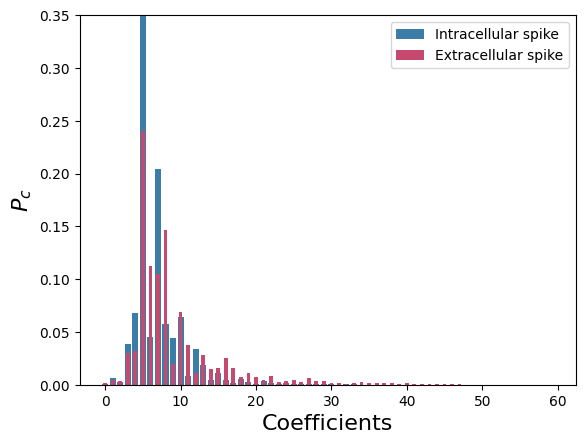

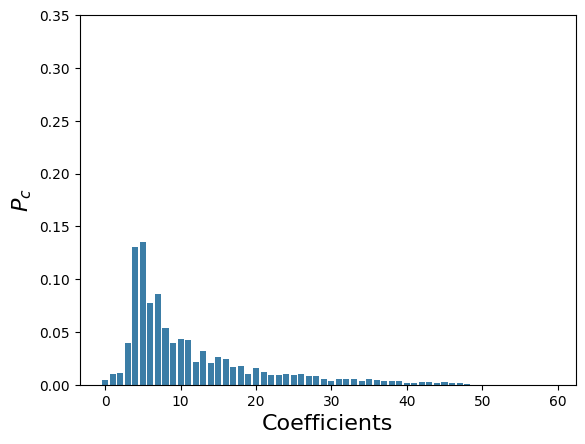

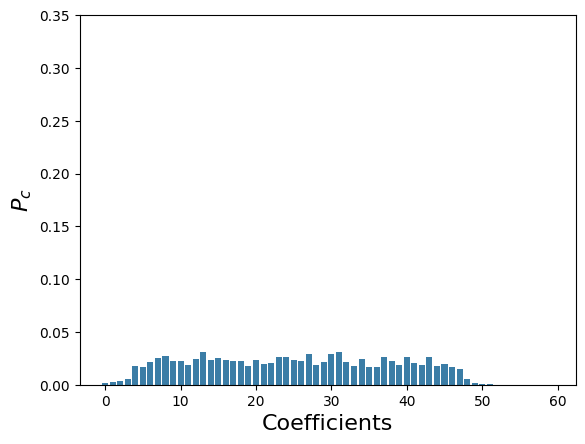

In [12]:
# set font sizes
plt.rc('font', size=10)      
plt.rc('axes', titlesize=16)     
plt.rc('axes', labelsize=16)    

# define P_c
vector = np.mean(c_mat_spike_in**2, axis=(1,2))

# normalize
total_sum = sum(vector)
measure = [element/total_sum for element in vector]


# same for extracellular spike
vector = np.mean(c_mat_spike**2, axis=(1,2))

total_sum = sum(vector)
measure1 = [element/total_sum for element in vector]

# Plot
plt.figure()
plt.ylim(0, 0.35)
# plt.title('Sum of total energy in each coefficient for signal')
plt.xlabel('Coefficients')
plt.ylabel('$P_c$')
plt.bar(np.arange(pp), measure ,color='#3B7DA6')
plt.bar(np.arange(pp), measure1, width=0.5, color='#C64A70')
plt.legend(['Intracellular spike', 'Extracellular spike'])


# Same for bg sinal
vector = np.mean(c_mat_noise**2, axis=(1,2))

total_sum = sum(vector)
measure = [element/total_sum for element in vector]
plt.figure()
plt.ylim(0, 0.35)
plt.xlabel('Coefficients')
plt.ylabel('$P_c$')
# plt.title('Sum of total energy in each coefficient for noise')
plt.bar(np.arange(pp), measure ,color='#3B7DA6')


# same for normal noise
vector = np.mean(c_mat_normal**2, axis=(1,2))

total_sum = sum(vector)
measure = [element/total_sum for element in vector]
plt.figure()
plt.ylim(0, 0.35)
plt.xlabel('Coefficients')
plt.ylabel('$P_c$')
# plt.title('Sum of total energy in each coefficient for normal distributed noise')
plt.bar(np.arange(pp), measure,color='#3B7DA6')

### Get similarity measure

In [13]:
# calculate similarity measure for coefficients in different channels.

# For spikes
c_spike = np.zeros((c_mat_spike.shape[0]*c_mat_spike.shape[1], c_mat_spike.shape[2]))
for j in range(c_mat_spike.shape[2]):
    for i in range(c_mat_spike.shape[1]):
        c_spike[c_mat_spike.shape[0]*i:c_mat_spike.shape[0]*i+c_mat_spike.shape[0], j] = c_mat_spike[:,i,j]

c_spike = c_spike / np.max(c_spike)

total_dist = 0
for j in range(4):
    for i in range(4):
        total_dist += np.linalg.norm(c_spike[:,i] - c_spike[:,j])

print('Sililarity measure for spikes')
print(round(total_dist,2))

# For bg signal 
c_noise = np.zeros((c_mat_noise.shape[0]*c_mat_noise.shape[1], c_mat_noise.shape[2]))
for j in range(c_mat_noise.shape[2]):
    for i in range(c_mat_noise.shape[1]):
        c_noise[c_mat_noise.shape[0]*i:c_mat_noise.shape[0]*i+c_mat_noise.shape[0], j] = c_mat_noise[:,i,j]
c_noise = c_noise / np.max(c_noise)

total_dist = 0
for j in range(4):
    for i in range(4):
        total_dist += np.linalg.norm(c_noise[:,i] - c_noise[:,j])

print('Sililarity measure for background signal')
print(round(total_dist,2))

# For normal noise
np.random.seed(1)
c_normal = np.random.normal(0, 1, size=(1200, 4))
c_normal = c_normal / np.max(c_normal)

total_dist = 0
for j in range(4):
    for i in range(4):
        total_dist += np.linalg.norm(c_normal[:,i] - c_normal[:,j])

print('Sililarity measure for normal noise')
print(round(total_dist,2))

Sililarity measure for spikes
26.82
Sililarity measure for background signal
61.96
Sililarity measure for normal noise
148.81


### Plot histograms

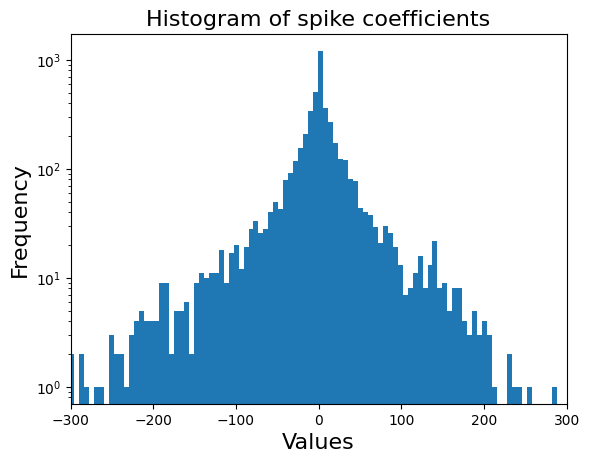

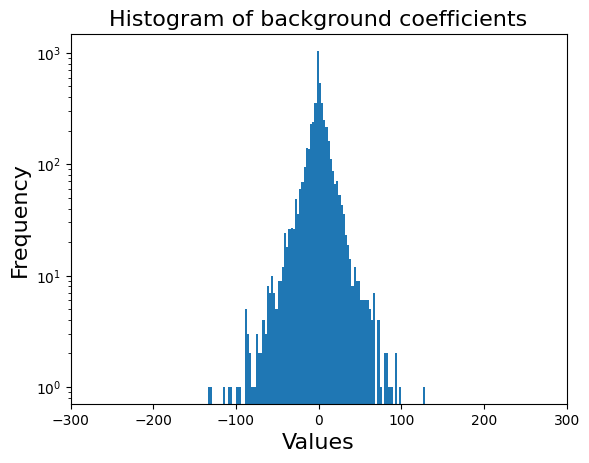

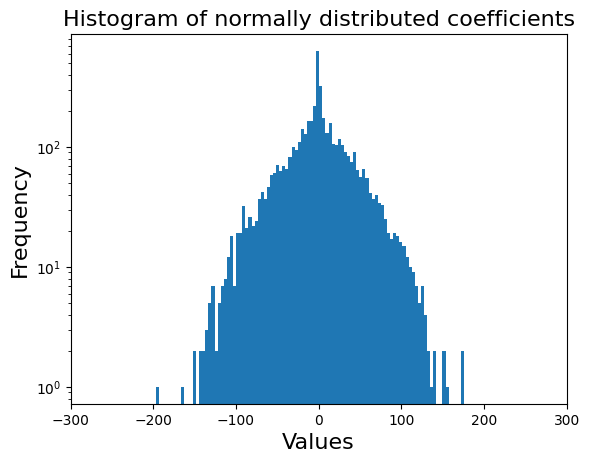

In [14]:
# plot histograms of value distributions

plt.hist(c_mat_spike.flatten(), bins=100)
plt.xlim(-300, 300)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spike coefficients')
plt.yscale('log')
plt.show()

plt.hist(c_mat_noise.flatten(), bins=100)
plt.xlim(-300, 300)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of background coefficients')
plt.yscale('log')
plt.show()

plt.hist(c_mat_normal.flatten(), bins=100)
plt.xlim(-300, 300)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of normally distributed coefficients')
plt.yscale('log')
plt.show()
